In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import itertools

from scipy.stats import pearsonr, spearmanr, zscore
from sklearn.metrics import r2_score

import os
from statsmodels.stats.multitest import multipletests

from tqdm import tqdm
import subprocess as sp

In [2]:
slopes1 = pd.read_csv('../code/IntronSlopes/slopes/NA19137.IntronWindows.glm_nb.tab.gz',
                     sep='\t', index_col=0)

slopes1 = slopes1.dropna()

slopes2 = pd.read_csv('../code/IntronSlopes/slopes/NA19238.IntronWindows.glm_nb.tab.gz',
                     sep='\t', index_col=0)

slopes2 = slopes2.dropna()

In [5]:
def plot_slopes(sample1, sample2, method='spearman'):
    
    
    slopes1 = sample1.Slope
    slopes2 = sample2.Slope
    
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    
    vmax = np.max((np.max(slopes1), np.max(slopes2))) 
    vmin = np.min((np.min(slopes1), np.min(slopes2))) 
    
    pad = np.abs(vmax - vmin)/20
    
    vmax += pad
    
    vmin = vmin - pad
    
    
    ax.plot([vmin, vmax], [0,0], 'r--', alpha=0.5)
    ax.plot([0,0], [vmin, vmax], 'r--', alpha=0.5)
    ax.scatter(slopes1, slopes2, c='black', alpha=0.2, linewidth=0)
    
#     r2 = round(r2_score(slopes1, slopes2),2)
#     ax.text(0.8, 0.1,'R2 = ' + str(r2), ha='center', va='center', transform=ax.transAxes)
    
    if method == 'spearman':
        r2 = round(spearmanr(slopes1, slopes2)[0],2)
        ax.text(0.8, 0.15,'Spearman', ha='center', va='center', transform=ax.transAxes)
        ax.text(0.8, 0.1,'r = ' + str(r2), ha='center', va='center', transform=ax.transAxes)
        
    elif method == 'pearson':
        r2 = round(pearsonr(slopes1, slopes2)[0],2)
        ax.text(0.8, 0.15,'Pearson', ha='center', va='center', transform=ax.transAxes)
        ax.text(0.8, 0.1,'r = ' + str(r2), ha='center', va='center', transform=ax.transAxes)
        
    elif method == 'r2_score':
        r2 = round(r2_score(slopes1, slopes2),2)
#         ax.text(0.8, 0.15,'Spearman', ha='center', va='center', transform=ax.transAxes)
        ax.text(0.79, 0.1,'R2 = ' + str(r2), ha='center', va='center', transform=ax.transAxes)
    
    
    
    
    neg_neg = round(np.mean(sample1.IsSlopeNegative & sample2.IsSlopeNegative)*100)
    neg_pos = round(np.mean(sample1.IsSlopeNegative & ~sample2.IsSlopeNegative)*100)
    pos_neg = round(np.mean(~sample1.IsSlopeNegative & sample2.IsSlopeNegative)*100)
    pos_pos = round(100 - neg_neg - neg_pos - pos_neg)
    
    if (neg_neg >= 0 ) and (neg_neg < 1 ):
        neg_neg = '<1'
    if (neg_pos >= 0 ) and (neg_pos < 1 ):
        neg_pos = '<1'
    if (pos_neg >= 0 ) and (pos_neg < 1 ):
        pos_neg = '<1'
    if (pos_pos >= 0 ) and (pos_pos < 1 ):
        pos_pos = '<1'
    
    ax.text(0.06, 0.03, str(neg_neg) + '%', ha='center', va='center', transform=ax.transAxes)
    
    ax.text(0.06, 0.96, str(neg_pos) + '%', ha='center', va='center', transform=ax.transAxes)
    
    ax.text(0.94, 0.03, str(pos_neg) + '%', ha='center', va='center', transform=ax.transAxes)
    
    ax.text(0.94, 0.96, str(pos_pos) + '%', ha='center', va='center', transform=ax.transAxes)
    
    
    ax.set_xlim((vmin, vmax))
    ax.set_ylim((vmin, vmax))
    ax.set_xlabel('NA19137')
    ax.set_ylabel('NA18855')
    ax.set_title('Slopes 100 windows')
    plt.show()

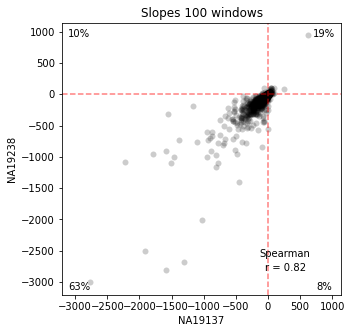

In [4]:
# slopes1 = slopes1.loc[(slopes1.coverageMean >= 0.95) & (slopes1.counts >= 1000) & (slopes1.IntronLength >= 10000)].copy()
# slopes2 = slopes2.loc[(slopes2.coverageMean >= 0.95) & (slopes2.counts >= 1000) & (slopes2.IntronLength >= 10000)].copy()

shared_idx = slopes1.dropna().index.intersection(slopes2.dropna().index)
plot_slopes(slopes1.loc[shared_idx], slopes2.loc[shared_idx], method='spearman')

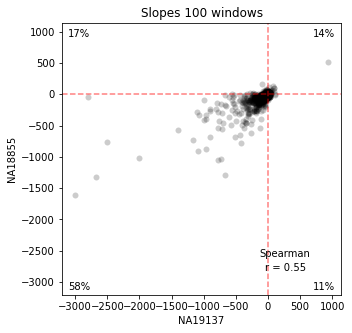

In [8]:
slopes2 = pd.read_csv('../code/IntronSlopes/slopes/NA18855.IntronWindows.glm_nb.tab.gz',
                     sep='\t', index_col=0)

slopes2 = slopes2.dropna()

slopes1 = pd.read_csv('../code/IntronSlopes/slopes/NA19238.IntronWindows.glm_nb.tab.gz',
                     sep='\t', index_col=0)

slopes1 = slopes1.dropna()


shared_idx = slopes1.dropna().index.intersection(slopes2.dropna().index)
plot_slopes(slopes1.loc[shared_idx], slopes2.loc[shared_idx], method='spearman')

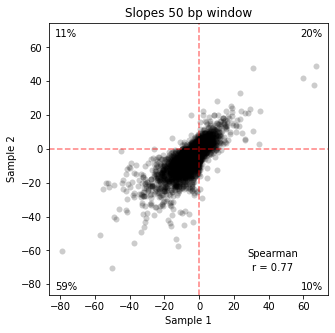

In [122]:
slopes1_sig = slopes1['std.error'].sort_values()[:10000].index
slopes2_sig = slopes2['std.error'].sort_values()[:10000].index

shared_sig = slopes1_sig.intersection(slopes2_sig)

plot_slopes(slopes1.loc[shared_sig], slopes2.loc[shared_sig], 'spearman')

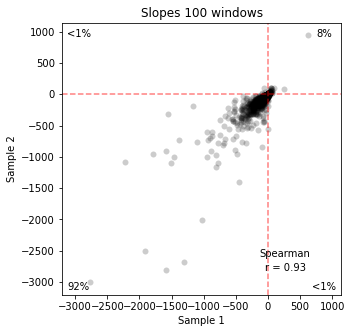

In [14]:
# slopes1 = slopes1.loc[(slopes1.coverageMean >= 0.9) & (slopes1.counts >= 10000) & (slopes1.IntronLength >= 10000)].copy()
# slopes2 = slopes2.loc[(slopes2.coverageMean >= 0.9) & (slopes2.counts >= 10000) & (slopes1.IntronLength >= 10000)].copy()

s1_fdr = multipletests(slopes1.dropna()['Slope.p.value'], method='fdr_bh', alpha=0.25)
slopes1['Slope.FDR'] = s1_fdr[1]
slopes1['Slope.IsSignificant'] = s1_fdr[0]
intercept1_fdr = multipletests(slopes1.dropna()['Intercept.p.value'], method='fdr_bh', alpha=0.25)
slopes1['Intercept.FDR'] = intercept1_fdr[1]
slopes1['Intercept.IsSignificant'] = intercept1_fdr[0]
slopes1['IsSignificant'] = slopes1['Slope.IsSignificant'] & slopes1['Intercept.IsSignificant']
slopes1_sig = slopes1.loc[slopes1.IsSignificant].index

s2_fdr = multipletests(slopes2.dropna()['Slope.p.value'], method='fdr_bh', alpha=0.25)
slopes2['Slope.FDR'] = s2_fdr[1]
slopes2['Slope.IsSignificant'] = s2_fdr[0]
intercept2_fdr = multipletests(slopes2.dropna()['Intercept.p.value'], method='fdr_bh', alpha=0.25)
slopes2['Intercept.FDR'] = intercept2_fdr[1]
slopes2['Intercept.IsSignificant'] = intercept2_fdr[0]
slopes2['IsSignificant'] = slopes2['Slope.IsSignificant'] & slopes2['Intercept.IsSignificant']
slopes2_sig = slopes2.loc[slopes2.IsSignificant].index

shared_sig = slopes1_sig.intersection(slopes2_sig)

plot_slopes(slopes1.loc[shared_sig], slopes2.loc[shared_sig], 'spearman')

In [129]:
slopes = pd.read_csv("../code/IntronSlopes/IntronWindowCounts/NA18522.IntronWindows.bed.gz", sep='\t',
                     names = ['chrom', 'start', 'end', 'bin', 'score', 'strand', 'counts'])

In [146]:
intron = ['_'.join(i.split('_')[:-1]) for i in slopes.bin]

In [147]:
slopes['intron'] = intron

In [148]:
sum_counts = slopes.groupby('intron').sum('counts')

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from scipy.stats import zscore
from tqdm import tqdm
import vcf
import subprocess as sp
import seaborn as sns
from scipy.stats import zscore

In [7]:
slopeQTLs = pd.read_csv('../code/QTLs/QTLTools/chRNA.Slopes/PermutationPass.FDR_Added.txt.gz', sep=' ', index_col=0)#,
slopes_qqnormed = pd.read_csv('../code/QTLs/QTLTools/chRNA.Slopes/OnlyFirstRepsForColoc.sorted.qqnorm.bed.gz', sep='\t')
sig_introns = list(slopeQTLs.index[slopeQTLs.q <= 0.1]) + ['ENSG00000184384.14_chr11_96093517_96341382_-']


In [11]:
def filter_vcf(vcf_file, region_list, out='filtered.vcf'):
    query_split = [x.split(':') for x in region_list]
    query = ['chr' + x[0] + ':' + x[1] for x in query_split]
    query = ','.join(query)
    
    cmd = 'bcftools view -r ' + query + ' ' + vcf_file + ' > ' + out
        
    sp.run(cmd, shell=True)
    
    
vcf_file = '../code/QTLs/QTLTools/chRNA.Slopes/Genotypes/WholeGenome.vcf.gz'

filter_vcf(vcf_file, list(slopeQTLs.loc[sig_introns].var_id))

vcf = pd.read_csv('filtered.vcf', skiprows=119, sep='\t', index_col=2)
samples = slopes_qqnormed.columns[6:].intersection(vcf.columns)

In [12]:
def plot_SNP(vcf, slopes, sQTLs, intron):
    
    samples = slopes.columns
    snp = sQTLs.loc[intron, 'var_id']
    dfSNP = pd.DataFrame(vcf.loc[snp, samples])
    dfSNP['slope'] = list(slopes.loc[intron, samples])
    zygosity = []
    
    var1 = snp.split(':')[-2]
    var2 = snp.split(':')[-1]
    
    zygosity_order = []
    
    list_00 = []
    list_01 = []
    list_11 = []
    
    for idx, row in dfSNP.iterrows():
#         return idx, row
        if row[snp] == '0|0':
            zygosity.append(var1 + ',' + var1)
            zygosity_order.append(0)
            list_00.append(idx)
        elif ((row[snp] == '0|1') or (row[snp] == '1|0')):
            zygosity.append(var1 + ',' + var2)
            zygosity_order.append(1)
            list_01.append(idx)
        else:
            zygosity.append(var2 + ',' + var2)
            zygosity_order.append(2)
            list_11.append(idx)
            
    print('0|0')
    print(list_00)
    print('0|1')
    print(list_01)
    print('1|1')
    print(list_11)

    dfSNP['zygosity'] = zygosity
    dfSNP['zygosity_order'] = zygosity_order
    
    dfSNP = dfSNP.sort_values('zygosity_order')
    
#     dfSNP

    print(snp)

    sns.boxplot(x="zygosity", y="slope", data=dfSNP, palette=x)
    sns.swarmplot(x="zygosity", y="slope", data=dfSNP, color=".25")
    intron_split = intron.split('_')
    intron_name = intron_split[1] + ':' + intron_split[2] + '-' + intron_split[3] + ':' + intron_split[4]
    plt.title(intron_name)
    plt.xlabel('SNP: ' + snp)
    plt.ylabel('slope qqnorm')
#     plt.savefig('plots/' + intron + '.png', dpi = 300)
    plt.show()
    
    return var1, var2

In [13]:
x = sns.color_palette("tab10")

Text(0, 0.5, 'Counts')

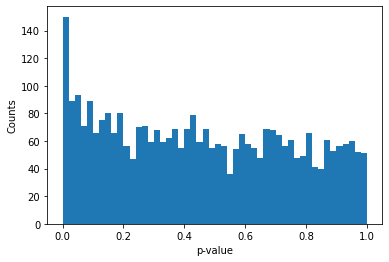

In [14]:
plt.hist(slopeQTLs.adj_beta_pval, bins=50)
plt.xlabel('p-value')
plt.ylabel('Counts')

In [15]:
valid_SNPs = np.array([x for x in slopeQTLs.loc[sig_introns].var_id if x in vcf.index])
valid_introns = [x[0] for x in slopeQTLs.loc[sig_introns].iterrows() if x[1].var_id in vcf.index]

In [16]:
slopes_qqnormed = slopes_qqnormed.set_index('pid')


In [17]:
slopes_qqnormed.index = [x.split(':')[0] for x in slopes_qqnormed.index]

ENSG00000134852.15_chr4_55510065_55545452_-
4:55530648:G:A


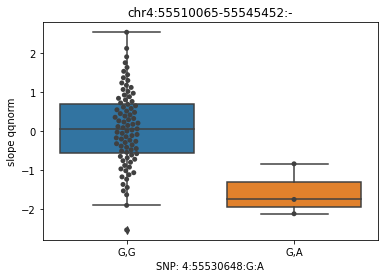

ENSG00000139734.19_chr13_59861536_59879228_-
13:59812260:C:G


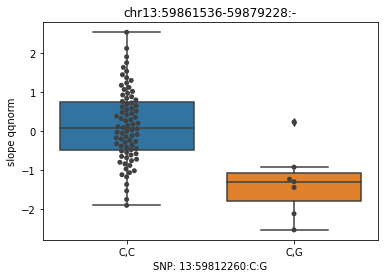

ENSG00000141627.13_chr18_49163787_49257009_-
18:49181422:AT:A


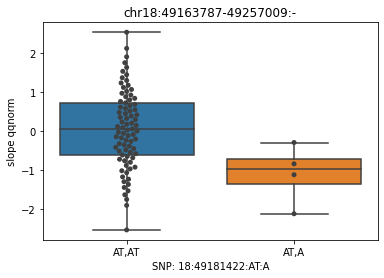

ENSG00000197372.10_chr19_23663158_23687030_-
19:23760671:ATT:A


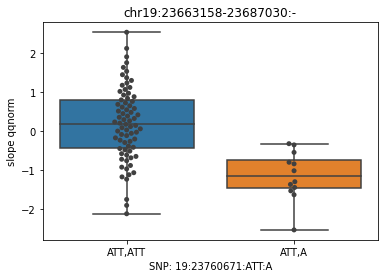

ENSG00000137642.13_chr11_121522989_121532463_+
11:121593621:CCCTTGTTTG:C


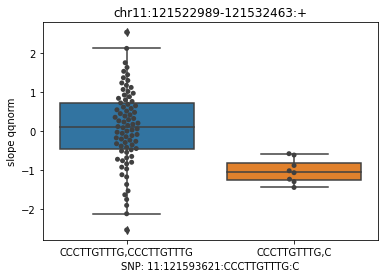

ENSG00000151413.17_chr14_31599379_31673354_+
14:31610780:C:T


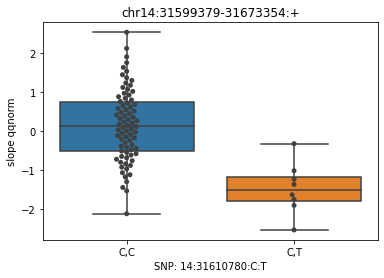

ENSG00000130449.6_chr5_61332948_61472680_+
5:61517304:G:A


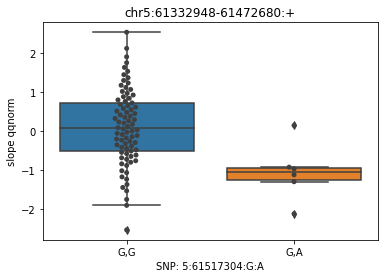

ENSG00000106771.13_chr9_109073438_109080838_-
9:109024075:G:T


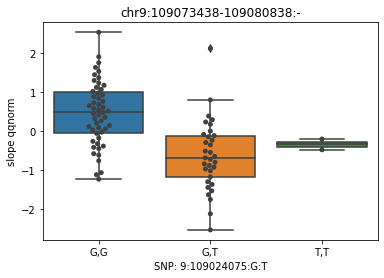

ENSG00000153944.11_chr17_57596950_57615969_+
17:57613341:C:A


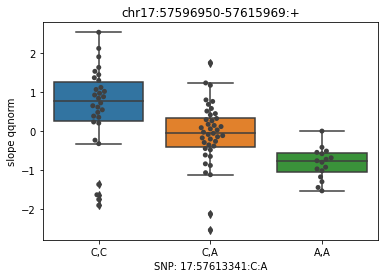

ENSG00000187231.14_chr2_179191866_179264498_-
2:179174942:TAA:T


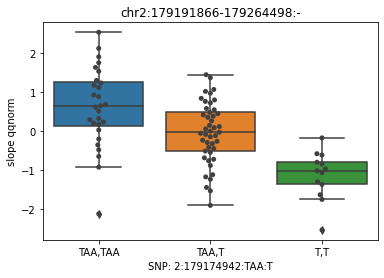

ENSG00000100991.12_chr20_35078174_35092613_-
20:35084320:A:T


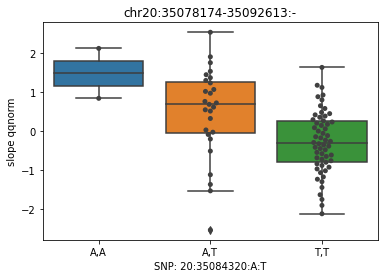

ENSG00000145734.19_chr5_71524323_71532307_+
5:71545840:T:TA


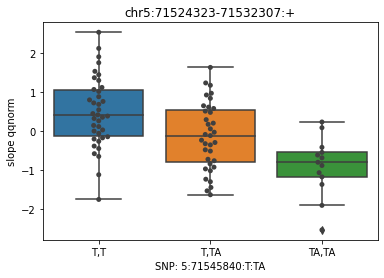

ENSG00000164483.17_chr6_130313093_130365119_-
6:130260408:A:G


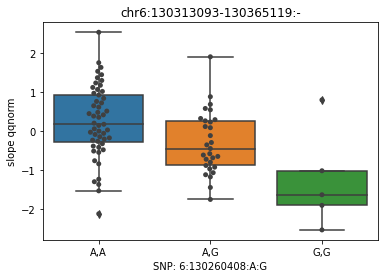

ENSG00000198216.12_chr1_181511510_181577765_+
1:181431091:T:A


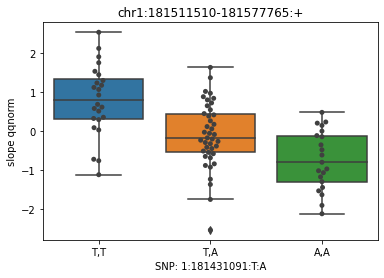

ENSG00000170832.13_chr17_60301704_60345480_-
17:60436879:C:G


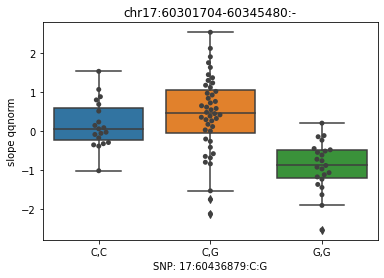

ENSG00000062725.10_chr17_60500487_60525793_-
17:60515112:A:AT


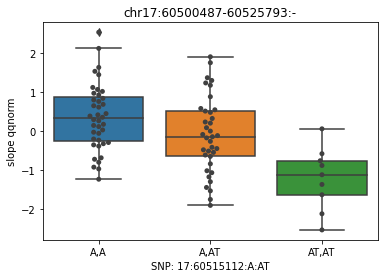

ENSG00000112584.13_chr6_170358318_170388286_+
6:170361258:G:A


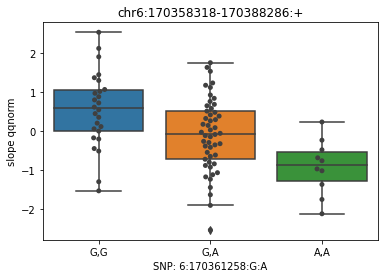

ENSG00000148120.16_chr9_94801002_94923985_+
9:94803579:G:A


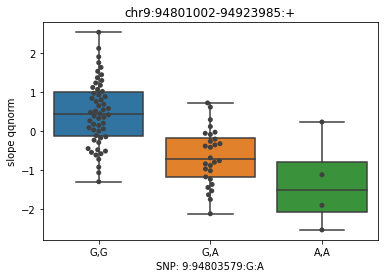

ENSG00000164574.16_chr5_154191025_154294815_+
5:154293610:TATA:T
ENSG00000168461.13_chr18_9708444_9775277_+
18:9710890:G:A


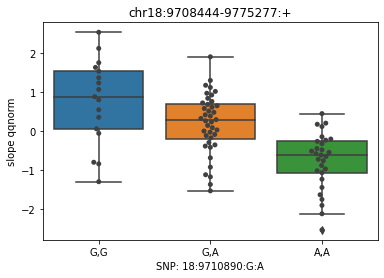

ENSG00000185420.19_chr1_245764149_245858495_-
1:245951167:A:G


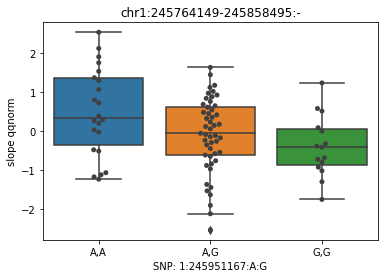

ENSG00000148498.16_chr10_34517159_34696317_-
10:34784456:TG:T


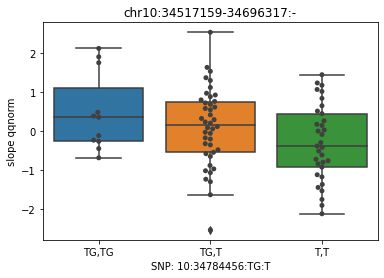

ENSG00000106392.11_chr7_7182820_7234302_+
7:7186143:CTCTT:C


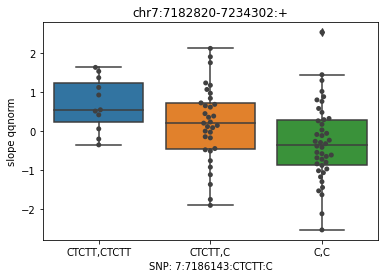

ENSG00000148498.16_chr10_34696419_34814875_-
10:34804035:GTTT:G


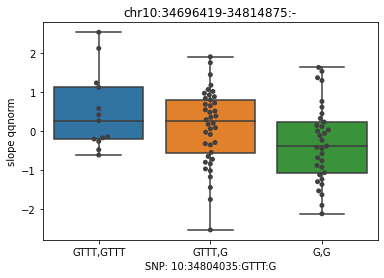

ENSG00000082068.9_chr5_37516590_37605063_+
5:37426950:A:T


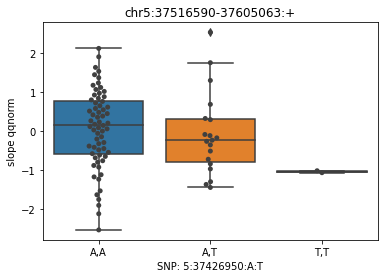

ENSG00000182185.18_chr14_67887204_68291883_+
14:68074029:T:C


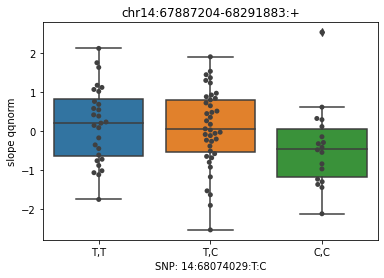

ENSG00000184384.14_chr11_96093517_96341382_-
11:96336038:A:T


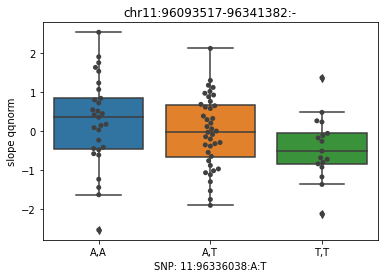

ENSG00000147316.13_chr8_6499929_6621453_+
8:6430345:C:T


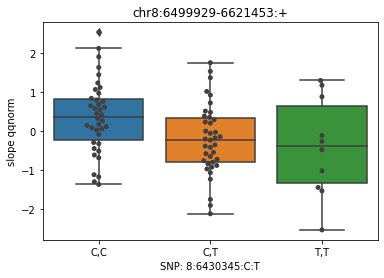

ENSG00000169504.15_chr1_24745625_24797741_+
1:24857185:C:T


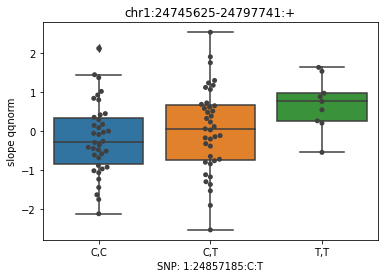

ENSG00000144791.10_chr3_45596287_45636149_+
3:45560733:G:A


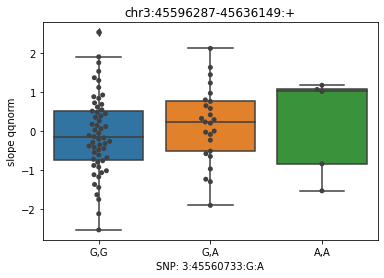

ENSG00000074054.18_chr2_121606180_121649371_-
2:121644346:A:G


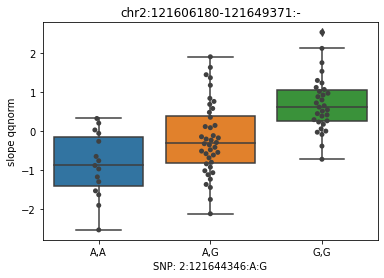

ENSG00000164494.12_chr6_107334332_107458989_-
6:107405846:CA:C


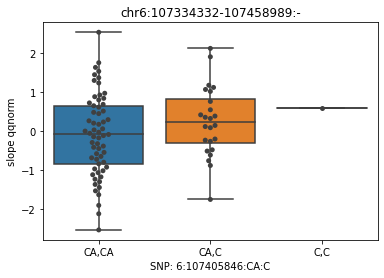

ENSG00000008256.16_chr7_6190531_6272473_-
7:6257212:T:C


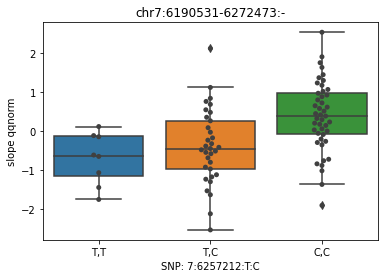

ENSG00000204217.15_chr2_202377550_202464808_+
2:202430722:A:G


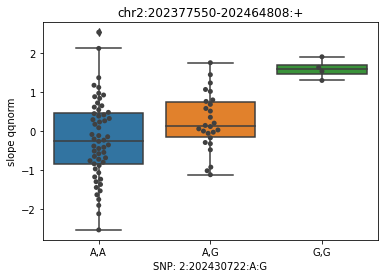

ENSG00000135862.6_chr1_183024134_183103327_+
1:183094939:C:CG


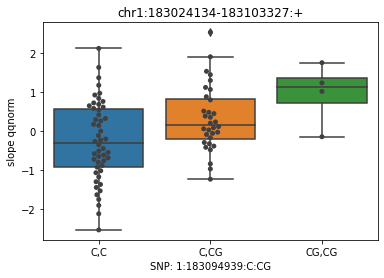

ENSG00000074054.18_chr2_121530325_121605700_-
2:121688700:C:T


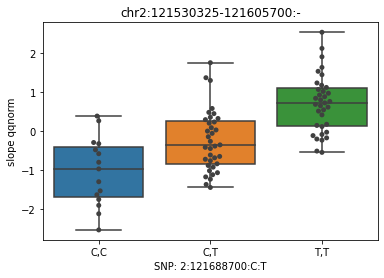

ENSG00000197535.14_chr15_52433285_52528779_-
15:52452846:TA:T


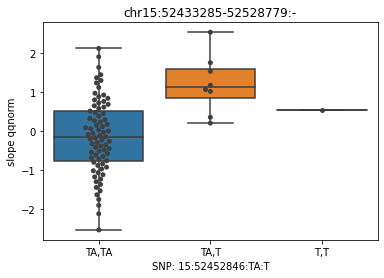

ENSG00000170310.15_chr17_9378653_9491828_-
17:9396665:G:C


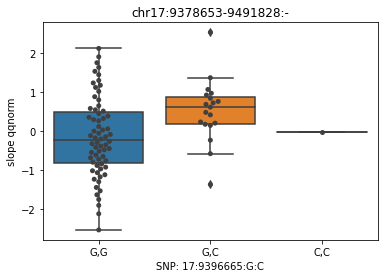

ENSG00000180611.7_chr3_192799650_192917629_-
3:192900531:G:C


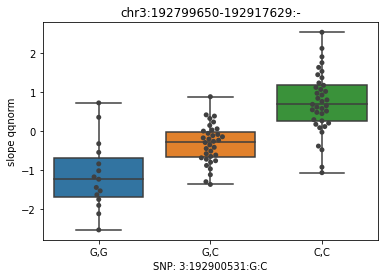

ENSG00000171045.16_chr8_142354763_142403103_-
8:142404143:G:A


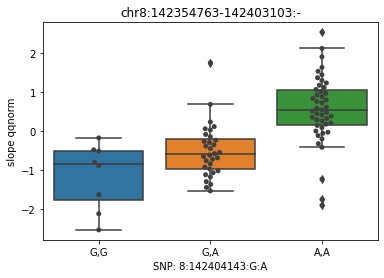

ENSG00000182670.13_chr21_37172744_37182773_+
21:37263872:C:G


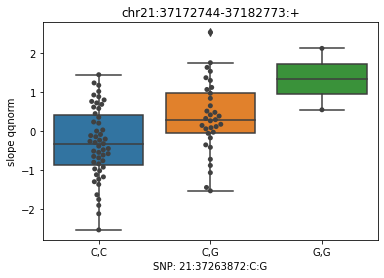

ENSG00000131374.14_chr3_17428519_17508473_-
3:17352698:A:C


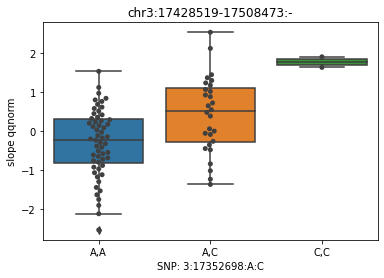

ENSG00000128607.14_chr7_130070809_130096920_+
7:130076465:T:G


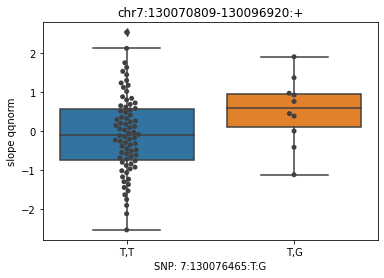

ENSG00000121895.8_chr4_38998909_39032225_-
4:39026377:A:AG


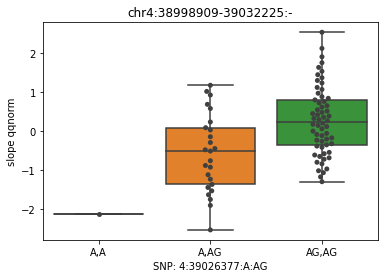

ENSG00000138101.18_chr2_25482873_25531472_-
2:25402553:G:GTC


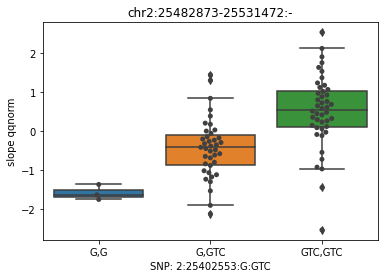

ENSG00000140386.13_chr15_76574284_76621763_-
15:76515331:G:C


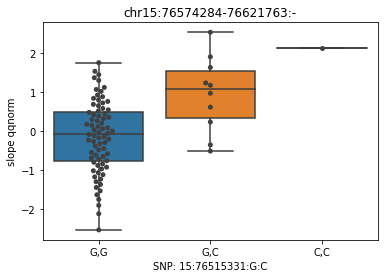

ENSG00000121749.15_chr12_71897941_71907021_+
12:71895390:T:C


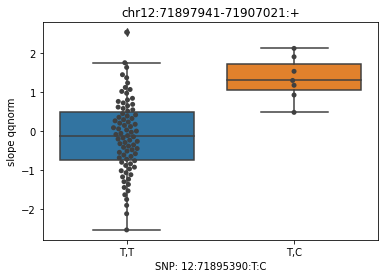

In [227]:
for intron in slopeQTLs.loc[valid_introns].sort_values('slope').index:
    print(intron)
    intron_idx = intron #+ intron.split('_')[0]
    try:
        plot_SNP(vcf, slopes_qqnormed[samples], slopeQTLs, intron_idx)
    except:
        continue

In [101]:
cmd = 'zcat ../code/IntronSlopes/IntronWindowCounts/NA19101.IntronWindows.bed.gz | '
cmd += 'grep ENSG00000198216.12_chr1_181511510_181577765_+'
tabla = sp.check_output(cmd, shell=True).decode()

In [110]:
df = pd.DataFrame([x.split('\t') for x in tabla.rstrip().split('\n')])

In [18]:
def processSampleIntron(IndID, intron):
    cmd = 'zcat ../code/IntronSlopes/IntronWindowCounts/{IndID}.IntronWindows.bed.gz | '.format(IndID=IndID)
    cmd += 'grep ' + intron
    tabla = sp.check_output(cmd, shell=True).decode()
    
    df = pd.DataFrame([x.split('\t') for x in tabla.rstrip().split('\n')])
    
    if df[5][0] == '+':
        return [int(x) for x in df[6]]
    else:
        return [int(x) for x in df[6]][::-1]

In [19]:
def plot_slopes_genotype(vcf, slopes, sQTLs, intron):
    
    samples = slopes.columns
    snp = sQTLs.loc[intron, 'var_id']
    dfSNP = pd.DataFrame(vcf.loc[snp, samples])
    dfSNP['slope'] = list(slopes.loc[intron, samples])
    zygosity = []
    
    var1 = snp.split(':')[-2]
    var2 = snp.split(':')[-1]
    
    
    AA = []
    AT = []
    TT = []
    
    
    for IndID, row in tqdm(dfSNP.iterrows(), leave=True, position=0):
        
#         print(IndID, intron)
        counts_list = processSampleIntron(IndID, intron)
        
        if row[snp] == '0|0':
            AA.append(counts_list)
#             list_00.append(IndID)
        elif ((row[snp] == '0|1') or (row[snp] == '1|0')):
            AT.append(counts_list)
#             list_01.append(IndID)
        else:
            TT.append(counts_list)
#             list_11.append(IndID)
            
#     print('0|0')
#     print(list_00)
#     print('0|1')
#     print(list_01)
#     print('1|1')
#     print(list_11)

    return AA, AT, TT

0|0
['NA18876', 'NA19209', 'NA18909', 'NA18934', 'NA18867', 'NA18923', 'NA18519', 'NA18522', 'NA18508', 'NA18523', 'NA19093', 'NA18520', 'NA19131', 'NA19257', 'NA19213', 'NA18862', 'NA18879', 'NA19160', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18853', 'NA19147', 'NA18864', 'NA19206', 'NA19098', 'NA19095']
0|1
['NA19096', 'NA19153', 'NA19143', 'NA19138', 'NA18877', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19141', 'NA19150', 'NA19092', 'NA19201', 'NA19236', 'NA18868', 'NA19121', 'NA19238', 'NA18510', 'NA18486', 'NA18910', 'NA19101', 'NA19108', 'NA19122', 'NA19190', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA18870', 'NA19198', 'NA18499', 'NA18915', 'NA18924', 'NA19225', 'NA19210', 'NA19171', 'NA18511', 'NA19128', 'NA18855', 'NA19184', 'NA19127', 'NA19130', 'NA18505', 'NA18852', 'NA19146']
1|1
['NA19214', 'NA19152', 'NA19119', 'NA19114', 'NA18497', 'NA19239', 'NA19117', 'NA19118', 'NA18504', 'NA18881', 'NA19207', 'NA18516', 'NA19200', 'NA18917']
2:179174942:TAA:T


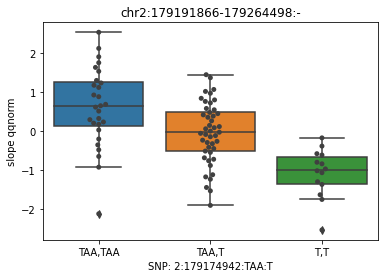

('TAA', 'T')

In [29]:
plot_SNP(vcf, slopes_qqnormed[samples], slopeQTLs, 'ENSG00000187231.14_chr2_179191866_179264498_-')

ENSG00000134852.15_chr4_55510065_55545452_-
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18522', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA19117', 'NA18862', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18915', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19098', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19152', 'NA19119', 

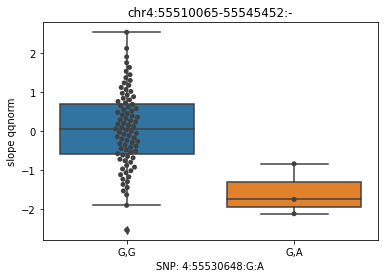

87it [04:03,  2.80s/it]


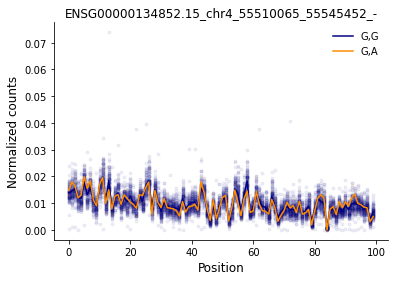

ENSG00000139734.19_chr13_59861536_59879228_-
0|0
['NA18876', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18498', 'NA19102', 'NA19117', 'NA18862', 'NA18870', 'NA18879', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18915', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA18855', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19098', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19214', 'NA19096', 'NA18522', 'NA18910', 'NA18502', 'NA19198', 'NA19147',

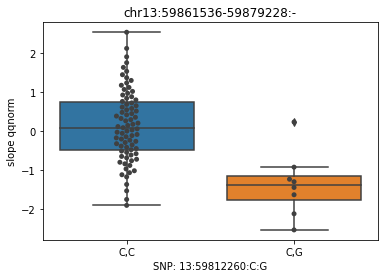

87it [03:59,  2.75s/it]


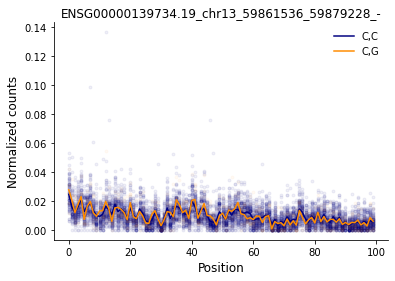

ENSG00000141627.13_chr18_49163787_49257009_-
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18522', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA19117', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19098', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19239', 'NA18862', 'NA18915',

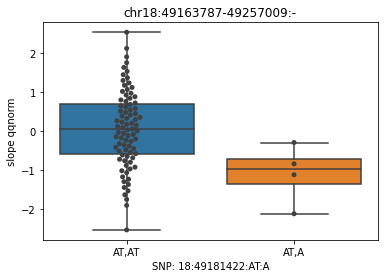

87it [03:59,  2.75s/it]


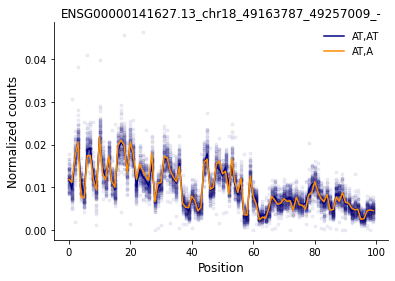

ENSG00000197372.10_chr19_23663158_23687030_-
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA19141', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18522', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA18498', 'NA19117', 'NA18862', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA18504', 'NA18915', 'NA18858', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA18505', 'NA18852', 'NA19206', 'NA19098', 'NA19200', 'NA19095']
0|1
['NA19209', 'NA18934', 'NA18523', 'NA19239', 'NA19102', 'NA19160', 'NA19247', 'NA19127', 'NA19130', 'NA18516', 'NA19146',

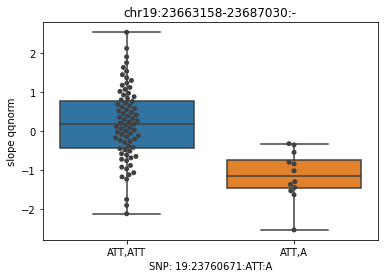

87it [04:06,  2.83s/it]


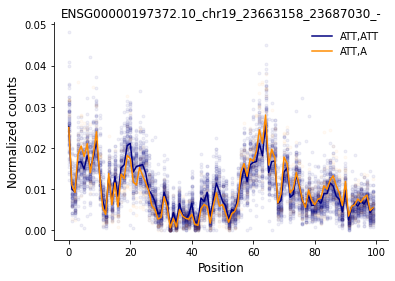

ENSG00000137642.13_chr11_121522989_121532463_+
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA19102', 'NA18862', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18915', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19098', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19152', 'NA19107', 'NA19201', 'NA18522', 'NA19093', 'NA18498', 'NA19117

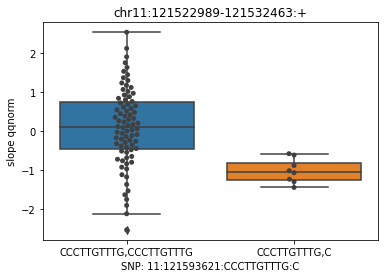

87it [04:10,  2.88s/it]


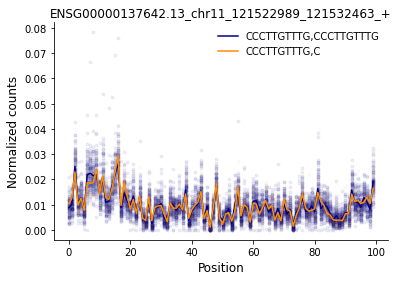

ENSG00000151413.17_chr14_31599379_31673354_+
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19209', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19114', 'NA19236', 'NA19121', 'NA18519', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA18498', 'NA19117', 'NA18862', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18915', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19152', 'NA19143', 'NA19201', 'NA18868', 'NA18522', 'NA19102', 'NA19147',

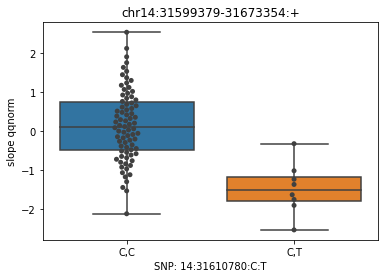

87it [04:02,  2.78s/it]


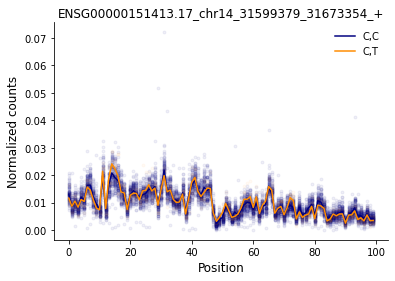

ENSG00000130449.6_chr5_61332948_61472680_+
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18522', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA19117', 'NA18862', 'NA18870', 'NA19198', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18915', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18852', 'NA19206', 'NA19098', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19201', 'NA18910', 'NA18879', 'NA19171', 'NA18505', '

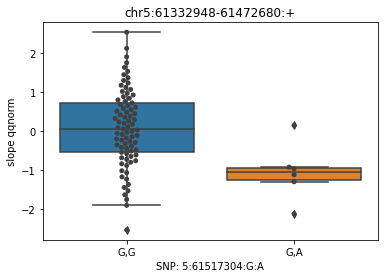

87it [04:04,  2.81s/it]


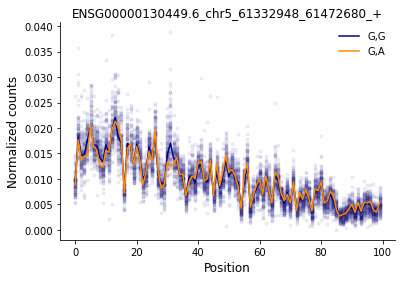

ENSG00000106771.13_chr9_109073438_109080838_-
0|0
['NA19096', 'NA19209', 'NA19143', 'NA19138', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19092', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA19121', 'NA18519', 'NA18497', 'NA18508', 'NA18510', 'NA18523', 'NA18486', 'NA19101', 'NA18520', 'NA19257', 'NA19108', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA19117', 'NA18862', 'NA19118', 'NA18504', 'NA18915', 'NA19247', 'NA18913', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19147', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19095', 'NA18917']
0|1
['NA19214', 'NA18876', 'NA19153', 'NA19152', 'NA18877', 'NA18909', 'NA19107', 'NA19141', 'NA19150', 'NA18867', 'NA18522', 'NA19238', 'NA19093', 'NA18910', 'NA19239', 'NA19131', 'NA19122', 'NA19190', 'NA19213', 'NA18870', 'NA19198', 'NA18499', 'NA19160', 'NA18858', 'NA19140', 'NA18924', 'NA19225', 'NA19210', 'NA19207', 'NA19128', 'NA18855', 'NA19098', 'NA19200', 'NA19146']
1|1
['NA1

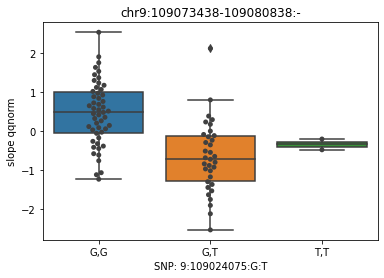

87it [04:03,  2.80s/it]


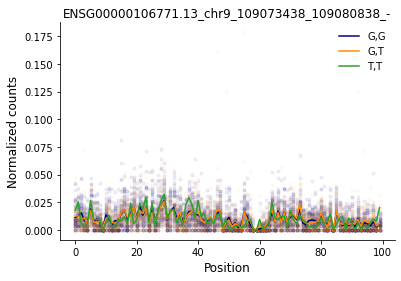

ENSG00000153944.11_chr17_57596950_57615969_+
0|0
['NA19096', 'NA18877', 'NA18909', 'NA19107', 'NA19137', 'NA19150', 'NA18923', 'NA19236', 'NA18868', 'NA18519', 'NA18523', 'NA18486', 'NA19101', 'NA18520', 'NA19131', 'NA19108', 'NA19122', 'NA19213', 'NA19102', 'NA19117', 'NA18870', 'NA19198', 'NA19247', 'NA18913', 'NA18924', 'NA19210', 'NA19207', 'NA18516', 'NA19206', 'NA19098']
0|1
['NA18876', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19203', 'NA18934', 'NA19141', 'NA18867', 'NA19092', 'NA18522', 'NA19238', 'NA18508', 'NA19093', 'NA19239', 'NA19257', 'NA18502', 'NA18498', 'NA18862', 'NA18879', 'NA18499', 'NA19118', 'NA19160', 'NA18915', 'NA18858', 'NA19140', 'NA19225', 'NA19171', 'NA18853', 'NA18511', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA19130', 'NA18505', 'NA18852', 'NA19200', 'NA19095']
1|1
['NA19214', 'NA19138', 'NA18507', 'NA19119', 'NA19201', 'NA19114', 'NA19121', 'NA18497', 'NA18510', 'NA18910', 'NA19190', 'NA19099', 'NA18504', 'NA18881', 'NA19127', 'NA19

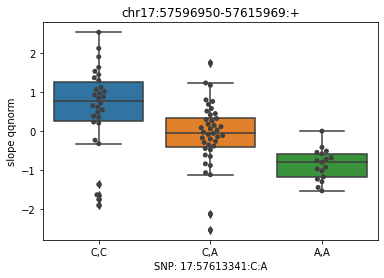

87it [04:08,  2.85s/it]


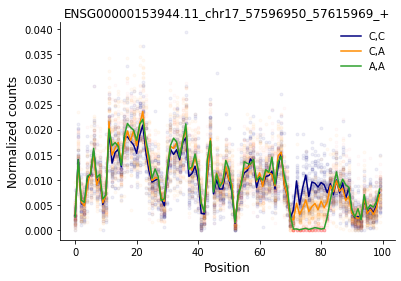

ENSG00000187231.14_chr2_179191866_179264498_-
0|0
['NA18876', 'NA19209', 'NA18909', 'NA18934', 'NA18867', 'NA18923', 'NA18519', 'NA18522', 'NA18508', 'NA18523', 'NA19093', 'NA18520', 'NA19131', 'NA19257', 'NA19213', 'NA18862', 'NA18879', 'NA19160', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18853', 'NA19147', 'NA18864', 'NA19206', 'NA19098', 'NA19095']
0|1
['NA19096', 'NA19153', 'NA19143', 'NA19138', 'NA18877', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19141', 'NA19150', 'NA19092', 'NA19201', 'NA19236', 'NA18868', 'NA19121', 'NA19238', 'NA18510', 'NA18486', 'NA18910', 'NA19101', 'NA19108', 'NA19122', 'NA19190', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA18870', 'NA19198', 'NA18499', 'NA18915', 'NA18924', 'NA19225', 'NA19210', 'NA19171', 'NA18511', 'NA19128', 'NA18855', 'NA19184', 'NA19127', 'NA19130', 'NA18505', 'NA18852', 'NA19146']
1|1
['NA19214', 'NA19152', 'NA19119', 'NA19114', 'NA18497', 'NA19239', 'NA19117', 'NA19118', 'NA18504', 'NA18881', 'NA19207', 'NA18516', 'NA1

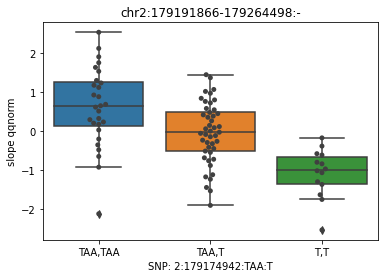

87it [04:08,  2.86s/it]


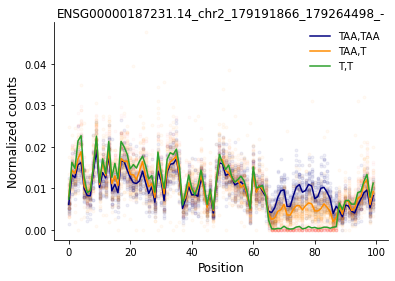

ENSG00000100991.12_chr20_35078174_35092613_-
0|0
['NA18867', 'NA19171']
0|1
['NA18876', 'NA19096', 'NA19209', 'NA19141', 'NA19150', 'NA19092', 'NA18522', 'NA19238', 'NA18510', 'NA18486', 'NA19108', 'NA19102', 'NA19117', 'NA18870', 'NA19198', 'NA18504', 'NA18858', 'NA19247', 'NA18924', 'NA19225', 'NA18853', 'NA19128', 'NA19184', 'NA18505', 'NA18852', 'NA19098', 'NA19200']
1|1
['NA19214', 'NA19153', 'NA19152', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18497', 'NA18508', 'NA18523', 'NA19093', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA18498', 'NA18862', 'NA18879', 'NA18499', 'NA19118', 'NA19160', 'NA18915', 'NA19140', 'NA18913', 'NA19210', 'NA18881', 'NA18511', 'NA19207', 'NA19147', 'NA18855', 'NA18864', 'NA19127', 'NA19130', 'NA18516', 'NA19206', 'NA19146', 'NA19

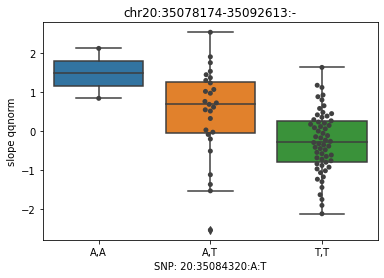

87it [04:26,  3.06s/it]


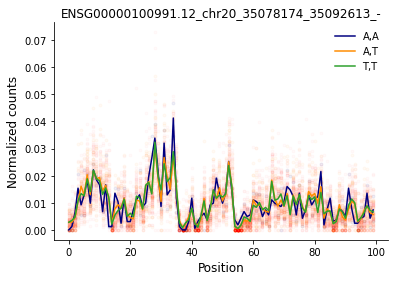

ENSG00000145734.19_chr5_71524323_71532307_+
0|0
['NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19203', 'NA19119', 'NA18934', 'NA18867', 'NA19092', 'NA18923', 'NA19201', 'NA19236', 'NA18497', 'NA19238', 'NA18510', 'NA18523', 'NA19093', 'NA19108', 'NA19213', 'NA18502', 'NA19117', 'NA18862', 'NA18870', 'NA18499', 'NA19160', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19147', 'NA18855', 'NA19184', 'NA19127', 'NA18516', 'NA18505', 'NA19200', 'NA19095']
0|1
['NA19214', 'NA18876', 'NA19153', 'NA19152', 'NA19107', 'NA18507', 'NA19137', 'NA19141', 'NA19114', 'NA18868', 'NA19121', 'NA18486', 'NA18910', 'NA19101', 'NA19239', 'NA19131', 'NA19257', 'NA19122', 'NA19190', 'NA19099', 'NA18498', 'NA19102', 'NA18879', 'NA19198', 'NA19118', 'NA18915', 'NA19225', 'NA18881', 'NA19171', 'NA18853', 'NA19207', 'NA19128', 'NA19130', 'NA18852', 'NA19098', 'NA19146']
1|1
['NA19096', 'NA19150', 'NA18519', 'NA18522', 'NA18508', 'NA18520', 'NA18504', 'NA18858', 'NA19210', 'NA18511', 'NA18864', 'NA192

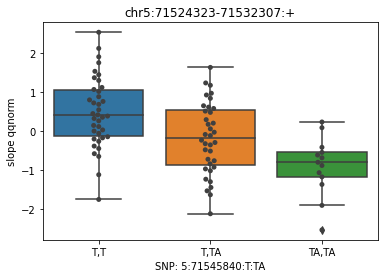

87it [04:21,  3.00s/it]


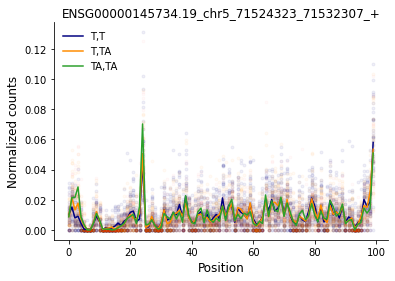

ENSG00000164483.17_chr6_130313093_130365119_-
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18507', 'NA19203', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA19114', 'NA19236', 'NA19121', 'NA18519', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA19093', 'NA18910', 'NA19239', 'NA19108', 'NA19190', 'NA18502', 'NA19117', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA18504', 'NA19160', 'NA18915', 'NA18858', 'NA19140', 'NA18913', 'NA19225', 'NA18881', 'NA19171', 'NA18511', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19127', 'NA18505', 'NA18852', 'NA19098']
0|1
['NA18909', 'NA19107', 'NA19119', 'NA19092', 'NA18923', 'NA19201', 'NA18868', 'NA18522', 'NA18486', 'NA19101', 'NA18520', 'NA19122', 'NA19213', 'NA19099', 'NA18498', 'NA19102', 'NA18862', 'NA19118', 'NA19247', 'NA18924', 'NA19210', 'NA19207', 'NA19184', 'NA19130', 'NA19206', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
1|1
['NA19137', 'NA19131', 'NA19257', 'NA1

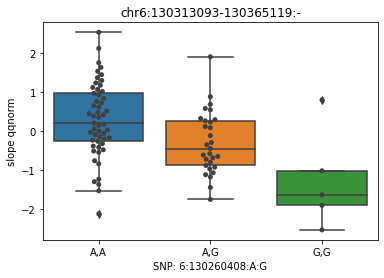

87it [04:06,  2.84s/it]


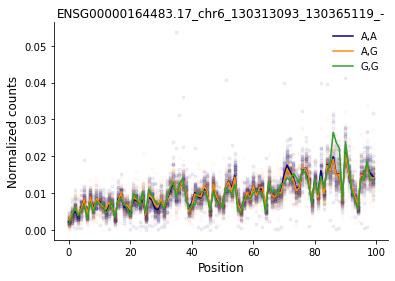

ENSG00000198216.12_chr1_181511510_181577765_+
0|0
['NA19153', 'NA18877', 'NA19203', 'NA19141', 'NA19114', 'NA18519', 'NA18508', 'NA18510', 'NA18486', 'NA18520', 'NA19239', 'NA19108', 'NA19122', 'NA18502', 'NA18862', 'NA19247', 'NA18924', 'NA19225', 'NA18853', 'NA19184', 'NA19127', 'NA18852', 'NA19200', 'NA19146']
0|1
['NA19214', 'NA19096', 'NA19152', 'NA19138', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19119', 'NA18934', 'NA18867', 'NA19092', 'NA19236', 'NA19121', 'NA18522', 'NA18497', 'NA18523', 'NA19101', 'NA19131', 'NA19190', 'NA19213', 'NA19099', 'NA19102', 'NA19117', 'NA18870', 'NA19198', 'NA18499', 'NA19118', 'NA19160', 'NA19140', 'NA18913', 'NA19210', 'NA18881', 'NA19171', 'NA18511', 'NA19207', 'NA19147', 'NA18855', 'NA18864', 'NA19206', 'NA19098', 'NA19095']
1|1
['NA18876', 'NA19209', 'NA19143', 'NA19150', 'NA18923', 'NA19201', 'NA18868', 'NA19238', 'NA19093', 'NA18910', 'NA19257', 'NA18498', 'NA18879', 'NA18504', 'NA18915', 'NA18858', 'NA19128', 'NA19130', 'NA18516', 'NA1

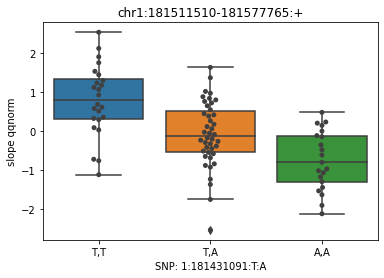

87it [04:02,  2.78s/it]


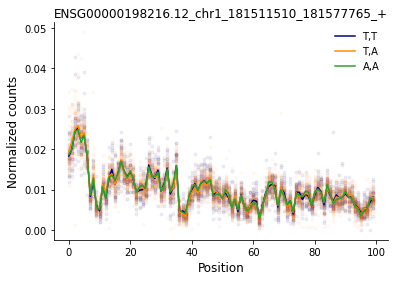

ENSG00000170832.13_chr17_60301704_60345480_-
0|0
['NA19152', 'NA19209', 'NA18934', 'NA19236', 'NA18520', 'NA19239', 'NA19108', 'NA19190', 'NA18502', 'NA19198', 'NA19160', 'NA19210', 'NA19171', 'NA18853', 'NA18855', 'NA18864', 'NA18852', 'NA19200', 'NA19095']
0|1
['NA18876', 'NA19153', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19141', 'NA19150', 'NA19092', 'NA19201', 'NA19114', 'NA18519', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA18910', 'NA19131', 'NA19122', 'NA19213', 'NA19102', 'NA19117', 'NA18862', 'NA18870', 'NA18499', 'NA19118', 'NA18858', 'NA18913', 'NA19225', 'NA18881', 'NA18511', 'NA19207', 'NA19128', 'NA19184', 'NA19130', 'NA18516', 'NA18505', 'NA19206', 'NA19098', 'NA18917']
1|1
['NA19214', 'NA19096', 'NA19203', 'NA19119', 'NA18867', 'NA18923', 'NA18868', 'NA19121', 'NA18522', 'NA19093', 'NA18486', 'NA19101', 'NA19257', 'NA19099', 'NA18498', 'NA18879', 'NA18504', 'NA18915', 'NA19247', 'NA19140', 'NA18924', 'NA19147', 'NA19

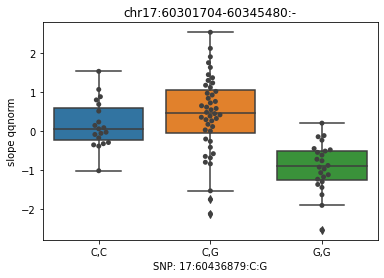

87it [04:04,  2.80s/it]


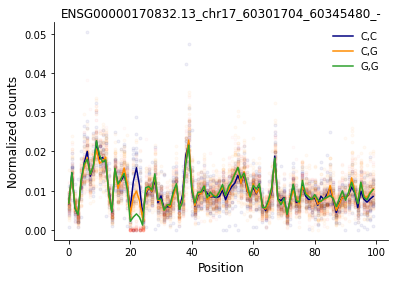

ENSG00000062725.10_chr17_60500487_60525793_-
0|0
['NA19214', 'NA18876', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18507', 'NA19203', 'NA19119', 'NA19141', 'NA19201', 'NA19114', 'NA19236', 'NA19121', 'NA18519', 'NA18497', 'NA18508', 'NA18510', 'NA18523', 'NA18910', 'NA18520', 'NA19108', 'NA19190', 'NA18498', 'NA19102', 'NA18862', 'NA19160', 'NA18858', 'NA19210', 'NA18881', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA18516', 'NA18852', 'NA19206', 'NA19098', 'NA19200', 'NA19095']
0|1
['NA19153', 'NA18909', 'NA19107', 'NA19137', 'NA18934', 'NA19150', 'NA18867', 'NA19092', 'NA18868', 'NA18522', 'NA19238', 'NA19093', 'NA18486', 'NA19239', 'NA19131', 'NA19122', 'NA19213', 'NA19099', 'NA18502', 'NA19117', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA18915', 'NA19247', 'NA19140', 'NA19225', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19127', 'NA18505', 'NA19146', 'NA18917']
1|1
['NA19096', 'NA18877', 'NA18923', 'NA19101', 'NA19257', 'NA18504', 'NA18913', 'NA18

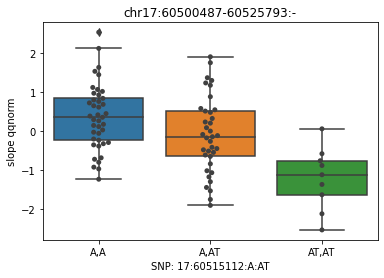

87it [04:03,  2.80s/it]


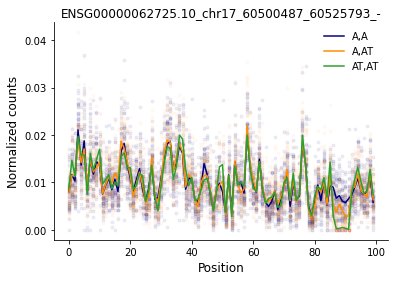

ENSG00000112584.13_chr6_170358318_170388286_+
0|0
['NA18876', 'NA19152', 'NA19143', 'NA18877', 'NA18909', 'NA19107', 'NA19141', 'NA19150', 'NA18923', 'NA18519', 'NA18522', 'NA19238', 'NA18510', 'NA19239', 'NA19257', 'NA19108', 'NA19213', 'NA19140', 'NA18913', 'NA18924', 'NA19171', 'NA19207', 'NA19128', 'NA19130', 'NA18505', 'NA19200']
0|1
['NA19214', 'NA19096', 'NA19153', 'NA19138', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA19092', 'NA19201', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18497', 'NA18523', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19131', 'NA19122', 'NA19190', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA18862', 'NA18870', 'NA19198', 'NA18499', 'NA18504', 'NA19160', 'NA18858', 'NA19247', 'NA19225', 'NA19210', 'NA18881', 'NA18853', 'NA18511', 'NA19147', 'NA18855', 'NA18864', 'NA19127', 'NA18516', 'NA18852', 'NA19206', 'NA19098', 'NA19146', 'NA19095']
1|1
['NA19209', 'NA18934', 'NA18867', 'NA18508', 'NA19117', 'NA18879', 'NA19118', 'NA18915', 'NA1

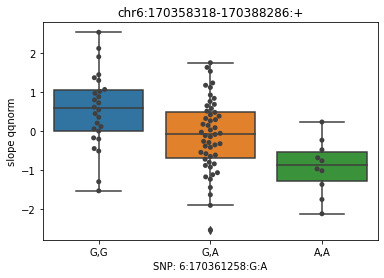

87it [04:03,  2.80s/it]


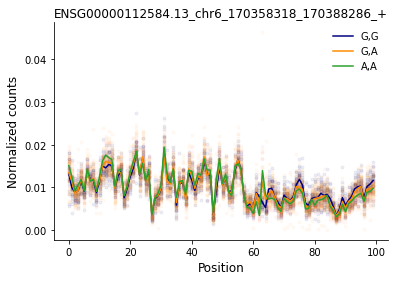

ENSG00000148120.16_chr9_94801002_94923985_+
0|0
['NA19214', 'NA18876', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA19107', 'NA18507', 'NA19203', 'NA19150', 'NA18867', 'NA18923', 'NA19201', 'NA18519', 'NA18497', 'NA18508', 'NA18510', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA19108', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA19117', 'NA18879', 'NA19198', 'NA18499', 'NA18504', 'NA18915', 'NA18858', 'NA19247', 'NA19140', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18855', 'NA19184', 'NA19127', 'NA19130', 'NA18505', 'NA18852', 'NA19206', 'NA19200', 'NA19095']
0|1
['NA18909', 'NA19137', 'NA19119', 'NA18934', 'NA19141', 'NA19092', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA19238', 'NA18523', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19122', 'NA19213', 'NA18870', 'NA19118', 'NA19160', 'NA18913', 'NA19171', 'NA18864', 'NA18516', 'NA19098', 'NA19146', 'NA18917']
1|1
['NA19096', 'NA18522', 'NA191

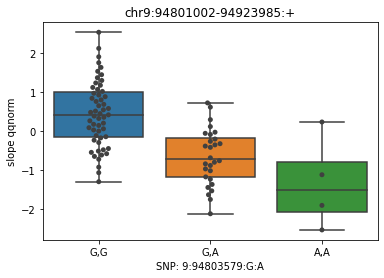

87it [04:02,  2.78s/it]


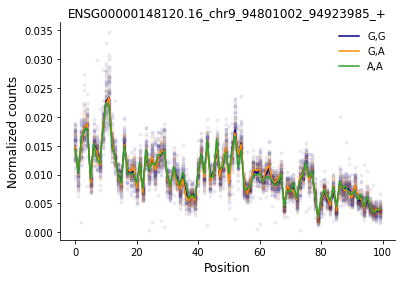

ENSG00000164574.16_chr5_154191025_154294815_+
0|0
['NA18876', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA18877', 'NA19107', 'NA19137', 'NA19141', 'NA19150', 'NA18867', 'NA18923', 'NA19236', 'NA18868', 'NA18519', 'NA18522', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA19093', 'NA18486', 'NA18520', 'NA19131', 'NA19257', 'NA19108', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA19102', 'NA19117', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19247', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA18853', 'NA19128', 'NA19127', 'NA19130', 'NA18505', 'NA18852', 'NA19206', 'NA19098', 'NA19200', 'NA19146', 'NA18917']
0|1
['NA19214', 'NA19096', 'NA19138', 'NA18909', 'NA18507', 'NA19203', 'NA19119', 'NA18934', 'NA19092', 'NA19201', 'NA19114', 'NA18523', 'NA18910', 'NA19101', 'NA19239', 'NA19122', 'NA18498', 'NA19118', 'NA18504', 'NA19160', 'NA18858', 'NA19171', 'NA18511', 'NA19207', 'NA18855', 'NA18864', 'NA19184', 'NA18516']
1|1
['NA19121', 'NA18862', 'NA18915', 'NA19140', 'NA1

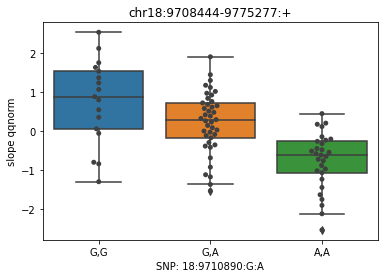

87it [04:02,  2.79s/it]


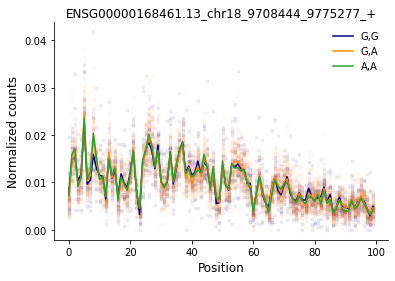

ENSG00000185420.19_chr1_245764149_245858495_-
0|0
['NA19153', 'NA19143', 'NA18877', 'NA19107', 'NA18507', 'NA19137', 'NA19150', 'NA19114', 'NA18522', 'NA18497', 'NA19101', 'NA18520', 'NA19239', 'NA19190', 'NA19099', 'NA19117', 'NA18879', 'NA18504', 'NA18853', 'NA18511', 'NA19184', 'NA18505']
0|1
['NA19214', 'NA19096', 'NA19152', 'NA19209', 'NA19138', 'NA18909', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA18867', 'NA18923', 'NA19201', 'NA19236', 'NA18868', 'NA19121', 'NA18508', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA18910', 'NA19131', 'NA19257', 'NA19122', 'NA19213', 'NA18498', 'NA18870', 'NA19198', 'NA18499', 'NA18915', 'NA19247', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA19171', 'NA19207', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19127', 'NA19130', 'NA18516', 'NA19206', 'NA19098', 'NA19200', 'NA19146', 'NA18917']
1|1
['NA18876', 'NA19092', 'NA18519', 'NA19238', 'NA19108', 'NA18502', 'NA19102', 'NA18862', 'NA19118', 'NA19160', 'NA18858', 'NA19140', 'NA18881', 'NA1

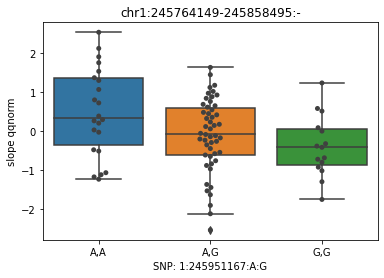

87it [04:01,  2.78s/it]


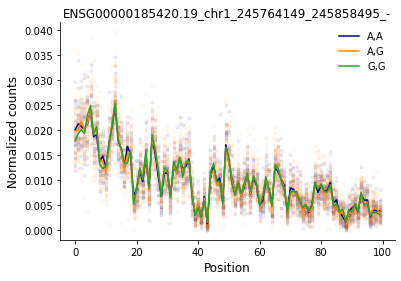

ENSG00000148498.16_chr10_34517159_34696317_-
0|0
['NA19152', 'NA18909', 'NA19137', 'NA19092', 'NA19099', 'NA18498', 'NA19198', 'NA19118', 'NA19247', 'NA18913', 'NA18853']
0|1
['NA18876', 'NA19153', 'NA19138', 'NA18507', 'NA18867', 'NA18923', 'NA19114', 'NA18868', 'NA18522', 'NA18497', 'NA19238', 'NA18510', 'NA18523', 'NA19131', 'NA19257', 'NA19122', 'NA19190', 'NA18502', 'NA19102', 'NA19117', 'NA18862', 'NA18879', 'NA18499', 'NA19160', 'NA18915', 'NA18858', 'NA19140', 'NA18924', 'NA18881', 'NA19171', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19098', 'NA19146']
1|1
['NA19214', 'NA19096', 'NA19209', 'NA19143', 'NA18877', 'NA19107', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA19201', 'NA19236', 'NA19121', 'NA18519', 'NA18508', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19108', 'NA19213', 'NA18870', 'NA18504', 'NA19225', 'NA19210', 'NA18511', 'NA19207', 'NA19130', 'NA19200', 'NA19

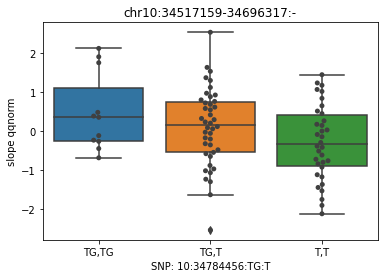

87it [04:01,  2.77s/it]


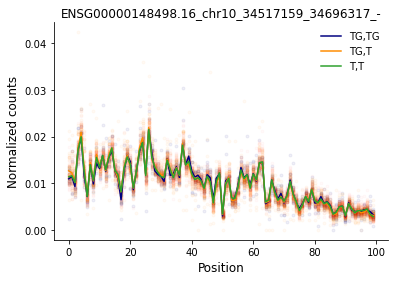

ENSG00000106392.11_chr7_7182820_7234302_+
0|0
['NA19153', 'NA19138', 'NA19119', 'NA19114', 'NA19238', 'NA18520', 'NA19239', 'NA19122', 'NA18502', 'NA18870', 'NA19127']
0|1
['NA19214', 'NA19096', 'NA19152', 'NA19209', 'NA19143', 'NA19107', 'NA18934', 'NA19141', 'NA19150', 'NA18519', 'NA18523', 'NA19093', 'NA18486', 'NA19131', 'NA19108', 'NA19190', 'NA19213', 'NA19102', 'NA19198', 'NA18915', 'NA18858', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA18855', 'NA19184', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19200', 'NA19095', 'NA18917']
1|1
['NA18876', 'NA18877', 'NA18909', 'NA18507', 'NA19137', 'NA19203', 'NA18867', 'NA19092', 'NA18923', 'NA19201', 'NA19236', 'NA18868', 'NA19121', 'NA18522', 'NA18497', 'NA18508', 'NA18510', 'NA18910', 'NA19101', 'NA19257', 'NA19099', 'NA18498', 'NA19117', 'NA18862', 'NA18879', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA19247', 'NA19210', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18864', 'NA19206', 'NA19098

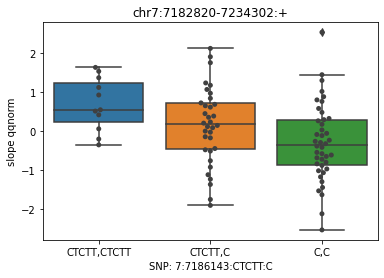

87it [04:03,  2.80s/it]


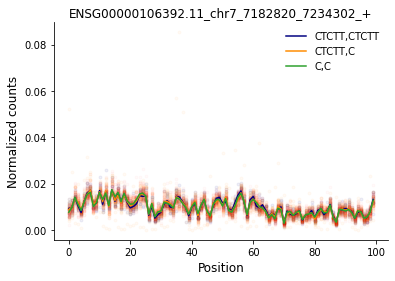

ENSG00000148498.16_chr10_34696419_34814875_-
0|0
['NA19152', 'NA18909', 'NA19137', 'NA19092', 'NA18523', 'NA19099', 'NA18498', 'NA19198', 'NA19118', 'NA19247', 'NA18913', 'NA18853', 'NA18864']
0|1
['NA18876', 'NA19153', 'NA19138', 'NA18507', 'NA18867', 'NA18923', 'NA19114', 'NA18868', 'NA18522', 'NA18497', 'NA19238', 'NA18510', 'NA19131', 'NA19257', 'NA19122', 'NA19190', 'NA18502', 'NA19102', 'NA19117', 'NA18862', 'NA18879', 'NA18499', 'NA18504', 'NA19160', 'NA18915', 'NA18858', 'NA19140', 'NA18924', 'NA18881', 'NA19171', 'NA19128', 'NA19147', 'NA18855', 'NA19184', 'NA19127', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19098']
1|1
['NA19214', 'NA19096', 'NA19209', 'NA19143', 'NA18877', 'NA19107', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA19201', 'NA19236', 'NA19121', 'NA18519', 'NA18508', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19108', 'NA19213', 'NA18870', 'NA19225', 'NA19210', 'NA18511', 'NA19207', 'NA19130', 'NA19200', 'NA19146', 'NA19

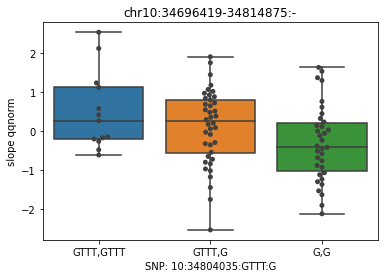

87it [04:00,  2.77s/it]


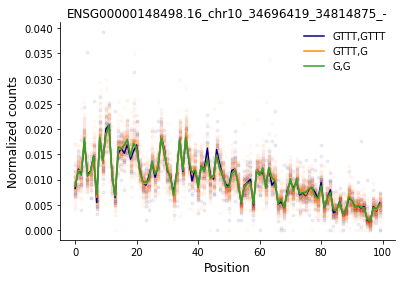

ENSG00000082068.9_chr5_37516590_37605063_+
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18522', 'NA19238', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19122', 'NA19213', 'NA19099', 'NA19102', 'NA18870', 'NA18879', 'NA19198', 'NA19118', 'NA18504', 'NA18915', 'NA18858', 'NA19247', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18864', 'NA19184', 'NA19127', 'NA18516', 'NA18505', 'NA19206', 'NA19146', 'NA18917']
0|1
['NA19143', 'NA18507', 'NA19137', 'NA18497', 'NA18508', 'NA19190', 'NA18502', 'NA19117', 'NA18862', 'NA18499', 'NA19160', 'NA19140', 'NA18881', 'NA18855', 'NA19130', 'NA18852', 'NA19098', 'NA19200', 'NA19095']
1|1
['NA1910

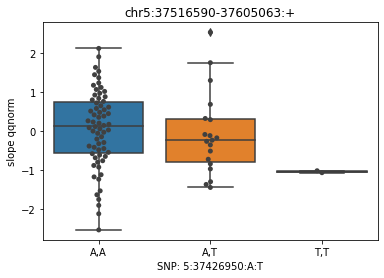

87it [04:02,  2.79s/it]


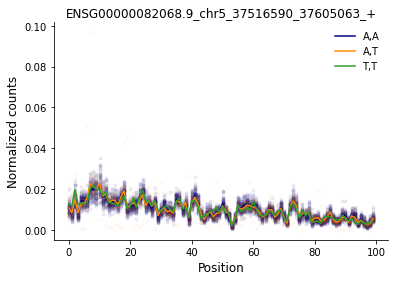

ENSG00000182185.18_chr14_67887204_68291883_+
0|0
['NA18876', 'NA19152', 'NA19143', 'NA18909', 'NA18507', 'NA19119', 'NA18867', 'NA18923', 'NA18519', 'NA19238', 'NA18508', 'NA19093', 'NA19108', 'NA19213', 'NA19099', 'NA18498', 'NA19102', 'NA19117', 'NA18862', 'NA18504', 'NA18913', 'NA19210', 'NA18853', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19200']
0|1
['NA19214', 'NA19096', 'NA19153', 'NA19209', 'NA19138', 'NA18877', 'NA19107', 'NA19203', 'NA18934', 'NA19141', 'NA19150', 'NA19114', 'NA19236', 'NA18868', 'NA18497', 'NA18510', 'NA18523', 'NA18910', 'NA19101', 'NA18520', 'NA19131', 'NA19257', 'NA18502', 'NA18870', 'NA18879', 'NA19198', 'NA19160', 'NA18915', 'NA18858', 'NA19247', 'NA19140', 'NA19225', 'NA19171', 'NA19207', 'NA19128', 'NA19147', 'NA19184', 'NA19127', 'NA19130', 'NA19146', 'NA19095']
1|1
['NA19137', 'NA19092', 'NA19201', 'NA19121', 'NA18522', 'NA18486', 'NA19239', 'NA19122', 'NA19190', 'NA18499', 'NA19118', 'NA18924', 'NA18881', 'NA18511', 'NA18855', 'NA18864', 'NA19

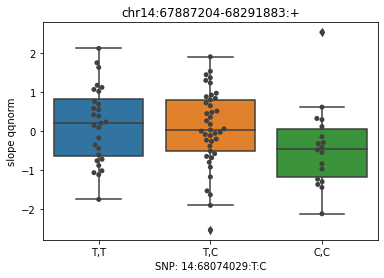

87it [04:07,  2.84s/it]


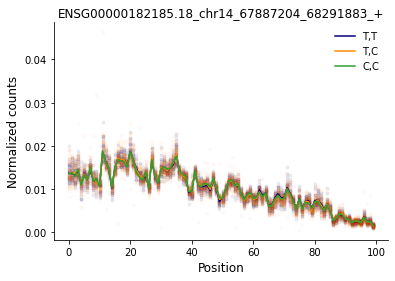

ENSG00000184384.14_chr11_96093517_96341382_-
0|0
['NA19096', 'NA19153', 'NA18507', 'NA18934', 'NA19141', 'NA19150', 'NA19092', 'NA18923', 'NA18497', 'NA19238', 'NA18510', 'NA18486', 'NA19101', 'NA19239', 'NA19108', 'NA19122', 'NA19099', 'NA18498', 'NA19102', 'NA18858', 'NA18913', 'NA18924', 'NA18855', 'NA19184', 'NA18505', 'NA18852', 'NA19206', 'NA19200', 'NA18917']
0|1
['NA19214', 'NA18876', 'NA19209', 'NA19143', 'NA19138', 'NA18909', 'NA19137', 'NA19203', 'NA19119', 'NA19114', 'NA19121', 'NA18508', 'NA18523', 'NA18910', 'NA18520', 'NA19131', 'NA19190', 'NA18502', 'NA19117', 'NA18879', 'NA19198', 'NA18499', 'NA18504', 'NA19160', 'NA18915', 'NA19247', 'NA19140', 'NA19225', 'NA19210', 'NA18881', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA19127', 'NA19130', 'NA18516', 'NA19098', 'NA19146', 'NA19095']
1|1
['NA19152', 'NA18877', 'NA19107', 'NA18867', 'NA19201', 'NA19236', 'NA18868', 'NA18519', 'NA18522', 'NA19093', 'NA19257', 'NA19213', 'NA18862', 'NA18870', 'NA19118', 'NA19

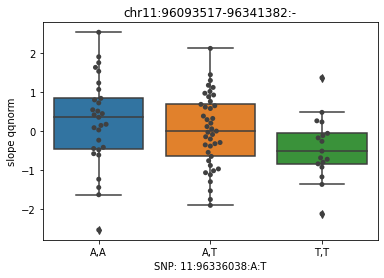

87it [04:05,  2.82s/it]


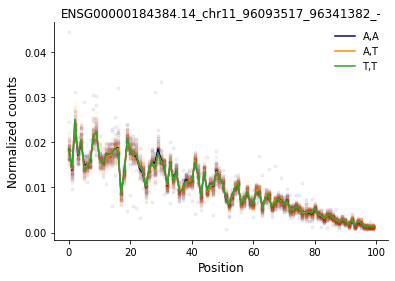

ENSG00000147316.13_chr8_6499929_6621453_+
0|0
['NA19153', 'NA18909', 'NA19107', 'NA18507', 'NA19203', 'NA19150', 'NA18867', 'NA19114', 'NA19121', 'NA18522', 'NA18508', 'NA18510', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19108', 'NA19102', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA18915', 'NA19140', 'NA18924', 'NA19210', 'NA18881', 'NA18511', 'NA19207', 'NA19128', 'NA18855', 'NA18864', 'NA19127', 'NA18852', 'NA19206', 'NA19098', 'NA19200', 'NA19146']
0|1
['NA18876', 'NA19096', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA19137', 'NA19119', 'NA19141', 'NA19092', 'NA18923', 'NA19201', 'NA18519', 'NA18497', 'NA19238', 'NA18523', 'NA19093', 'NA18910', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA19117', 'NA18862', 'NA19118', 'NA18504', 'NA18858', 'NA19247', 'NA19225', 'NA19171', 'NA18853', 'NA19184', 'NA18516', 'NA18505', 'NA19095', 'NA18917']
1|1
['NA19214', 'NA18934', 'NA19236', 'NA18868', 'NA18486', 'NA19257', 'NA18498', 'NA19160', 'NA18913', 'NA19147

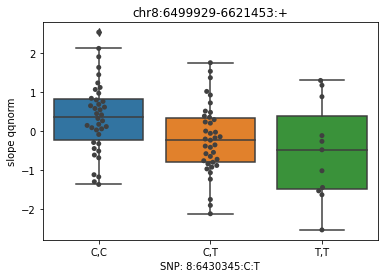

87it [04:04,  2.81s/it]


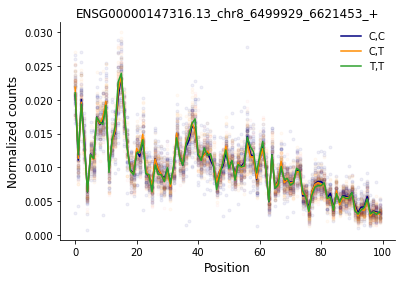

ENSG00000169504.15_chr1_24745625_24797741_+
0|0
['NA19214', 'NA18876', 'NA19152', 'NA19209', 'NA19143', 'NA18909', 'NA18507', 'NA19137', 'NA19150', 'NA18867', 'NA19092', 'NA19114', 'NA19236', 'NA18868', 'NA18519', 'NA18523', 'NA19101', 'NA18520', 'NA19239', 'NA19257', 'NA19099', 'NA19102', 'NA19117', 'NA18862', 'NA18870', 'NA19198', 'NA18499', 'NA19118', 'NA19160', 'NA18915', 'NA19247', 'NA18913', 'NA19225', 'NA18881', 'NA19171', 'NA19147', 'NA19184', 'NA19200', 'NA19146']
0|1
['NA19096', 'NA19153', 'NA19138', 'NA18877', 'NA19107', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA19093', 'NA19131', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA18502', 'NA18498', 'NA18879', 'NA18504', 'NA18858', 'NA18924', 'NA19210', 'NA18853', 'NA18511', 'NA19128', 'NA18855', 'NA18864', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19095', 'NA18917']
1|1
['NA18923', 'NA19201', 'NA19121', 'NA18522', 'NA18486', 'NA18910', 'NA19140', 'NA192

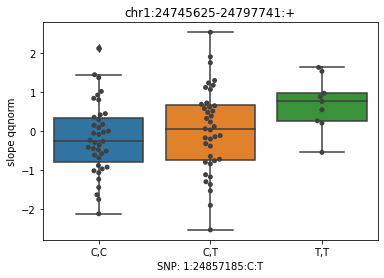

87it [04:04,  2.81s/it]


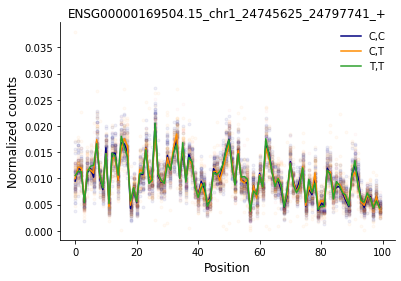

ENSG00000144791.10_chr3_45596287_45636149_+
0|0
['NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA18934', 'NA19141', 'NA18867', 'NA19201', 'NA19121', 'NA18522', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA19093', 'NA18910', 'NA19101', 'NA19239', 'NA19257', 'NA19122', 'NA19190', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA18862', 'NA19198', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18881', 'NA19171', 'NA18853', 'NA19128', 'NA18864', 'NA19184', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19214', 'NA18876', 'NA19119', 'NA19150', 'NA19092', 'NA18923', 'NA19114', 'NA18519', 'NA18486', 'NA18520', 'NA19131', 'NA19108', 'NA19213', 'NA19117', 'NA18870', 'NA18879', 'NA18915', 'NA19225', 'NA19210', 'NA18511', 'NA19207', 'NA19147', 'NA18855', 'NA19127', 'NA19130', 'NA19098']
1|1
['NA18909', 'NA19236', 'NA18868', 'NA185

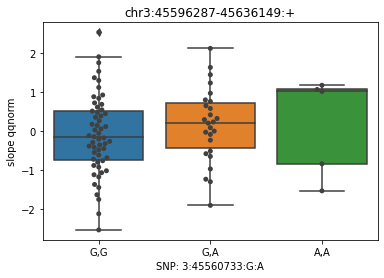

87it [04:04,  2.81s/it]


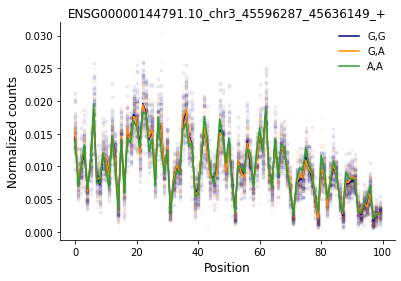

ENSG00000074054.18_chr2_121606180_121649371_-
0|0
['NA19143', 'NA18877', 'NA19150', 'NA19092', 'NA19121', 'NA19238', 'NA18510', 'NA18523', 'NA18910', 'NA19239', 'NA19131', 'NA18502', 'NA18870', 'NA18853', 'NA19128']
0|1
['NA19096', 'NA19153', 'NA19209', 'NA18909', 'NA19107', 'NA18507', 'NA19203', 'NA19119', 'NA19141', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA19093', 'NA18486', 'NA19257', 'NA19108', 'NA19190', 'NA19213', 'NA19102', 'NA19117', 'NA19198', 'NA18504', 'NA19160', 'NA18915', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA18881', 'NA18511', 'NA19147', 'NA18864', 'NA19184', 'NA19130', 'NA18516', 'NA18852', 'NA19098', 'NA19095', 'NA18917']
1|1
['NA19214', 'NA18876', 'NA19152', 'NA19138', 'NA19137', 'NA18934', 'NA18867', 'NA18868', 'NA18519', 'NA18522', 'NA18497', 'NA18508', 'NA19101', 'NA18520', 'NA19122', 'NA19099', 'NA18498', 'NA18862', 'NA18879', 'NA18499', 'NA19118', 'NA18858', 'NA19247', 'NA19210', 'NA19171', 'NA19207', 'NA18855', 'NA19127', 'NA18505', 'NA19206', 'NA1

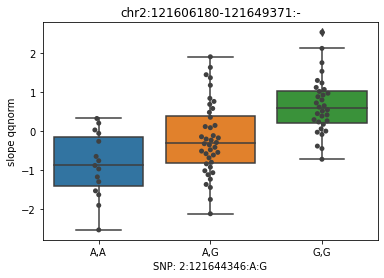

87it [04:03,  2.80s/it]


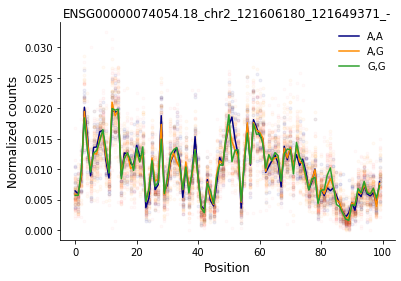

ENSG00000164494.12_chr6_107334332_107458989_-
0|0
['NA19214', 'NA18876', 'NA19153', 'NA19152', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA19137', 'NA19203', 'NA19119', 'NA19150', 'NA18867', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA19121', 'NA18497', 'NA18508', 'NA18523', 'NA19093', 'NA18910', 'NA19101', 'NA18520', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19213', 'NA19099', 'NA18502', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA19160', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18511', 'NA19207', 'NA19128', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19098', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19096', 'NA19209', 'NA18507', 'NA18934', 'NA19141', 'NA19092', 'NA18868', 'NA18519', 'NA18522', 'NA19238', 'NA18510', 'NA18486', 'NA19190', 'NA18498', 'NA19102', 'NA19117', 'NA18862', 'NA18504', 'NA18915', 'NA18881', 'NA19171', 'NA18853', 'NA19147', 'NA19200'

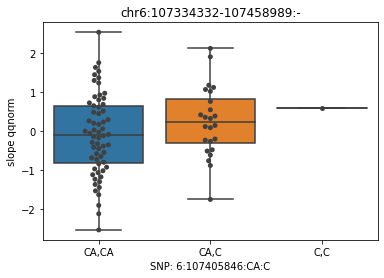

87it [04:02,  2.78s/it]


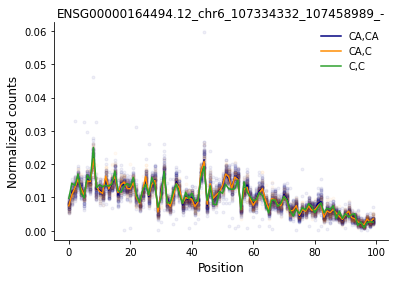

ENSG00000008256.16_chr7_6190531_6272473_-
0|0
['NA19131', 'NA18913', 'NA18881', 'NA18855', 'NA19184', 'NA19200', 'NA19095', 'NA18917']
0|1
['NA19096', 'NA19143', 'NA19138', 'NA18909', 'NA19119', 'NA18934', 'NA18867', 'NA19092', 'NA19201', 'NA18868', 'NA18519', 'NA18522', 'NA19238', 'NA18508', 'NA18523', 'NA19093', 'NA19257', 'NA19099', 'NA18502', 'NA19102', 'NA19117', 'NA18879', 'NA19198', 'NA19160', 'NA18915', 'NA19247', 'NA18853', 'NA18511', 'NA18864', 'NA18505', 'NA18852', 'NA19098', 'NA19146']
1|1
['NA19214', 'NA18876', 'NA19153', 'NA19152', 'NA19209', 'NA18877', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19141', 'NA19150', 'NA18923', 'NA19114', 'NA19236', 'NA19121', 'NA18497', 'NA18510', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA18498', 'NA18862', 'NA18870', 'NA18499', 'NA19118', 'NA18504', 'NA18858', 'NA19140', 'NA18924', 'NA19225', 'NA19210', 'NA19171', 'NA19207', 'NA19128', 'NA19147', 'NA19127', 'NA19130', 'NA18516

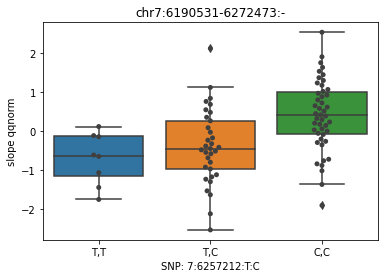

87it [04:03,  2.80s/it]


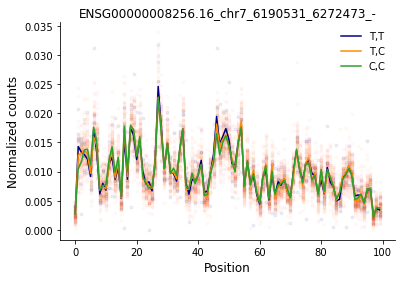

ENSG00000204217.15_chr2_202377550_202464808_+
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18909', 'NA19119', 'NA19141', 'NA19150', 'NA18923', 'NA19114', 'NA19236', 'NA18522', 'NA18497', 'NA18510', 'NA18523', 'NA18486', 'NA18910', 'NA19101', 'NA19257', 'NA19108', 'NA19190', 'NA19099', 'NA18498', 'NA19102', 'NA18862', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA18504', 'NA19160', 'NA18915', 'NA18858', 'NA19247', 'NA18913', 'NA18924', 'NA19225', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA19206', 'NA19200', 'NA19146', 'NA18917']
0|1
['NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA18934', 'NA18867', 'NA19092', 'NA19201', 'NA18868', 'NA19121', 'NA18519', 'NA19238', 'NA18508', 'NA19093', 'NA18520', 'NA19239', 'NA19131', 'NA19122', 'NA19213', 'NA18502', 'NA19140', 'NA19210', 'NA18505', 'NA18852', 'NA19098', 'NA19095']
1|1
['NA18877', 'NA19117', 'NA1

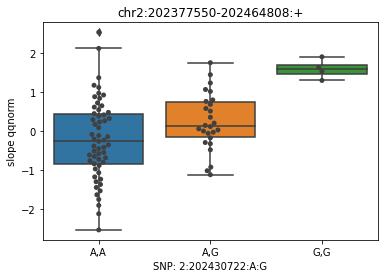

87it [04:02,  2.79s/it]


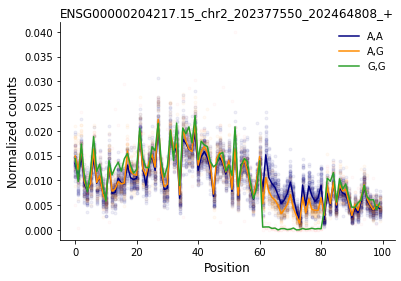

ENSG00000135862.6_chr1_183024134_183103327_+
0|0
['NA19214', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA19107', 'NA18507', 'NA19137', 'NA19141', 'NA18867', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA18868', 'NA18519', 'NA18522', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA19101', 'NA18520', 'NA19239', 'NA19213', 'NA19099', 'NA18502', 'NA19102', 'NA18862', 'NA19198', 'NA19160', 'NA18915', 'NA19140', 'NA18913', 'NA19225', 'NA19210', 'NA19171', 'NA18853', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA18917']
0|1
['NA18909', 'NA19203', 'NA19119', 'NA18934', 'NA19150', 'NA19092', 'NA19121', 'NA18497', 'NA19093', 'NA18910', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA18498', 'NA18870', 'NA18879', 'NA18499', 'NA19118', 'NA18504', 'NA18858', 'NA19247', 'NA18924', 'NA18511', 'NA19207', 'NA19128', 'NA19127', 'NA19098', 'NA19200', 'NA19146', 'NA19095']
1|1
['NA18876', 'NA18486', 'NA19

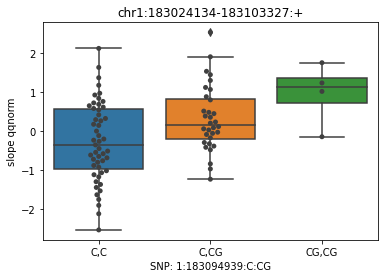

87it [04:01,  2.78s/it]


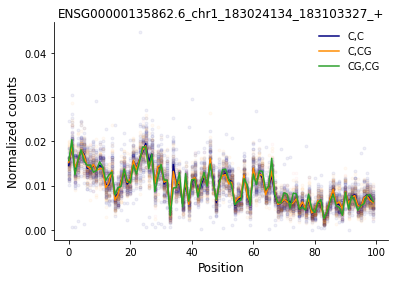

ENSG00000074054.18_chr2_121530325_121605700_-
0|0
['NA19143', 'NA18877', 'NA19150', 'NA19092', 'NA19121', 'NA19238', 'NA18510', 'NA18523', 'NA18910', 'NA19239', 'NA19131', 'NA18502', 'NA18870', 'NA18853', 'NA19128']
0|1
['NA19096', 'NA19153', 'NA19209', 'NA18909', 'NA19107', 'NA18507', 'NA19203', 'NA19119', 'NA19141', 'NA18923', 'NA19201', 'NA19114', 'NA19236', 'NA19093', 'NA18486', 'NA19257', 'NA19108', 'NA19213', 'NA19117', 'NA19198', 'NA18504', 'NA19160', 'NA18915', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA18881', 'NA18511', 'NA19147', 'NA18864', 'NA19184', 'NA19130', 'NA18516', 'NA18852', 'NA19098']
1|1
['NA19214', 'NA18876', 'NA19152', 'NA19138', 'NA19137', 'NA18934', 'NA18867', 'NA18868', 'NA18519', 'NA18522', 'NA18497', 'NA18508', 'NA19101', 'NA18520', 'NA19122', 'NA19190', 'NA19099', 'NA18498', 'NA19102', 'NA18862', 'NA18879', 'NA18499', 'NA19118', 'NA18858', 'NA19247', 'NA19210', 'NA19171', 'NA19207', 'NA18855', 'NA19127', 'NA18505', 'NA19206', 'NA19200', 'NA19146', 'NA1

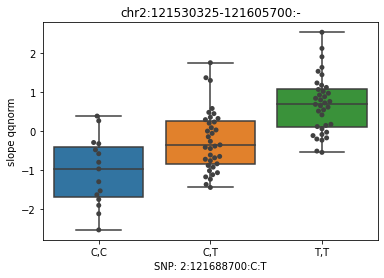

87it [03:59,  2.75s/it]


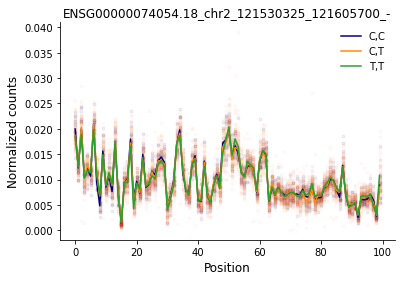

ENSG00000197535.14_chr15_52433285_52528779_-
0|0
['NA19214', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA18867', 'NA19092', 'NA19201', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18522', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA19117', 'NA18862', 'NA18870', 'NA18879', 'NA19198', 'NA19118', 'NA18504', 'NA19160', 'NA18915', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA18864', 'NA19184', 'NA19127', 'NA18505', 'NA18852', 'NA19206', 'NA19098', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA18876', 'NA18507', 'NA19150', 'NA18923', 'NA18499', 'NA19147', 'NA18855', 'NA19130']

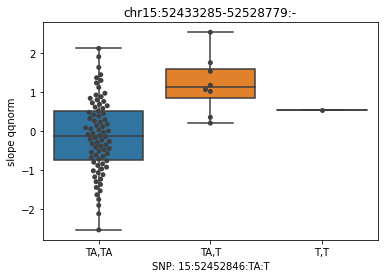

87it [04:00,  2.76s/it]


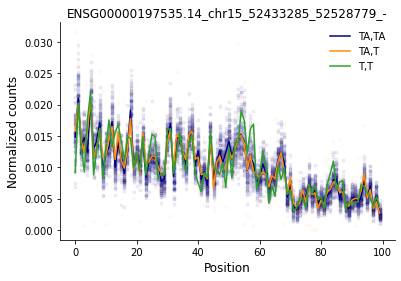

ENSG00000170310.15_chr17_9378653_9491828_-
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA19137', 'NA19119', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19114', 'NA19121', 'NA18519', 'NA18522', 'NA18497', 'NA19238', 'NA18510', 'NA18523', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA18502', 'NA18498', 'NA19117', 'NA18862', 'NA18870', 'NA18879', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18915', 'NA18858', 'NA18913', 'NA18924', 'NA19225', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA18507', 'NA19203', 'NA18934', 'NA19141', 'NA19201', 'NA19236', 'NA18868', 'NA18508', 'NA19093', 'NA19239', 'NA19213', 'NA19099', 'NA19102', 'NA19198', 'NA19247', 'NA19140', 'NA19210', 'NA18855', 'NA19098']
1

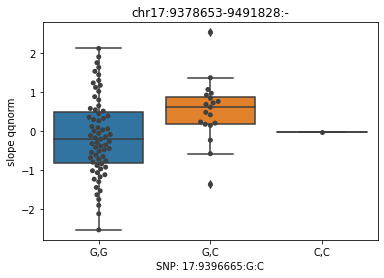

87it [04:00,  2.77s/it]


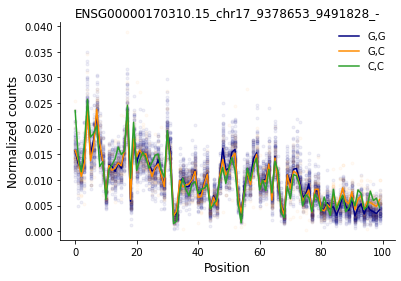

ENSG00000180611.7_chr3_192799650_192917629_-
0|0
['NA19153', 'NA19143', 'NA18507', 'NA18910', 'NA19257', 'NA18498', 'NA18870', 'NA18915', 'NA18858', 'NA18924', 'NA19210', 'NA18853', 'NA18855', 'NA19184', 'NA18852']
0|1
['NA18876', 'NA19096', 'NA18877', 'NA18909', 'NA19203', 'NA19119', 'NA18867', 'NA19092', 'NA19201', 'NA19114', 'NA18522', 'NA18497', 'NA18508', 'NA18510', 'NA18523', 'NA18520', 'NA19131', 'NA19122', 'NA19213', 'NA19099', 'NA18502', 'NA18862', 'NA18879', 'NA19198', 'NA18504', 'NA19247', 'NA18881', 'NA18511', 'NA19127', 'NA19130', 'NA18516', 'NA19098', 'NA19200', 'NA19095']
1|1
['NA19214', 'NA19152', 'NA19209', 'NA19138', 'NA19107', 'NA19137', 'NA18934', 'NA19141', 'NA19150', 'NA18923', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA19238', 'NA19093', 'NA18486', 'NA19101', 'NA19239', 'NA19108', 'NA19190', 'NA19102', 'NA19117', 'NA18499', 'NA19118', 'NA19160', 'NA19140', 'NA18913', 'NA19225', 'NA19171', 'NA19207', 'NA19128', 'NA19147', 'NA18864', 'NA18505', 'NA19206', 'NA19

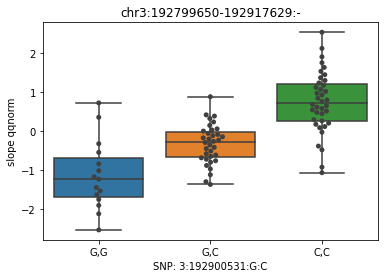

87it [04:01,  2.77s/it]


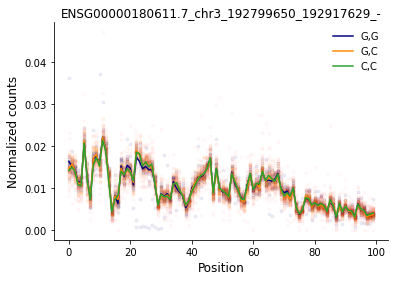

ENSG00000171045.16_chr8_142354763_142403103_-
0|0
['NA19152', 'NA19107', 'NA19114', 'NA18510', 'NA18924', 'NA19171', 'NA18853', 'NA19127']
0|1
['NA19214', 'NA18876', 'NA19153', 'NA18877', 'NA18909', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19150', 'NA19092', 'NA18868', 'NA18497', 'NA18486', 'NA18910', 'NA19101', 'NA19239', 'NA19213', 'NA19117', 'NA18870', 'NA18499', 'NA18915', 'NA19247', 'NA19210', 'NA19207', 'NA19147', 'NA18855', 'NA18864', 'NA19206', 'NA19098', 'NA19146', 'NA18917']
1|1
['NA19096', 'NA19209', 'NA19143', 'NA19138', 'NA19141', 'NA18867', 'NA18923', 'NA19201', 'NA19236', 'NA19121', 'NA18519', 'NA18522', 'NA19238', 'NA18508', 'NA18523', 'NA19093', 'NA18520', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA18862', 'NA18879', 'NA19198', 'NA19118', 'NA18504', 'NA19160', 'NA18858', 'NA19140', 'NA18913', 'NA19225', 'NA18881', 'NA18511', 'NA19128', 'NA19184', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA1

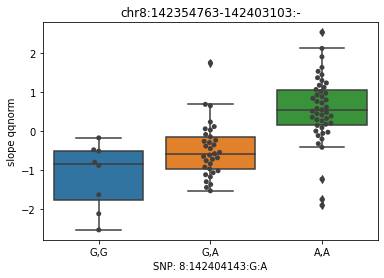

87it [03:59,  2.75s/it]


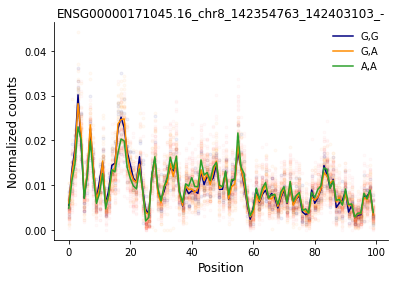

ENSG00000182670.13_chr21_37172744_37182773_+
0|0
['NA18876', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA18877', 'NA18909', 'NA19107', 'NA19137', 'NA19141', 'NA19150', 'NA19092', 'NA18923', 'NA19201', 'NA19236', 'NA19121', 'NA19238', 'NA18508', 'NA18910', 'NA18520', 'NA19239', 'NA19108', 'NA19099', 'NA18502', 'NA19102', 'NA18862', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19210', 'NA19171', 'NA18853', 'NA18511', 'NA19128', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18505', 'NA19206', 'NA19098', 'NA19095']
0|1
['NA19096', 'NA19138', 'NA18507', 'NA19203', 'NA19119', 'NA18934', 'NA18867', 'NA19114', 'NA18868', 'NA18522', 'NA18497', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA19101', 'NA19257', 'NA19122', 'NA19190', 'NA19213', 'NA18498', 'NA19117', 'NA18915', 'NA19225', 'NA18881', 'NA19207', 'NA19147', 'NA18855', 'NA18516', 'NA18852', 'NA19200', 'NA19146', 'NA18917']
1|1
['NA19214', 'NA18

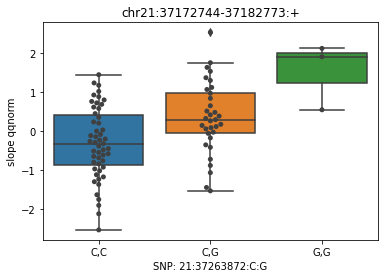

87it [04:01,  2.77s/it]


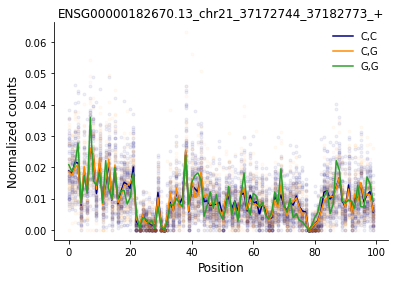

ENSG00000131374.14_chr3_17428519_17508473_-
0|0
['NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA18923', 'NA19201', 'NA19114', 'NA19121', 'NA18519', 'NA18508', 'NA18510', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19108', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA19117', 'NA19198', 'NA18915', 'NA18858', 'NA19247', 'NA19140', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA18864', 'NA19130', 'NA18516', 'NA18505', 'NA19200', 'NA19095', 'NA18917']
0|1
['NA19143', 'NA19092', 'NA19236', 'NA18868', 'NA18522', 'NA18497', 'NA18523', 'NA19122', 'NA19213', 'NA18862', 'NA18870', 'NA18879', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA19147', 'NA18855', 'NA19184', 'NA19127', 'NA18852', 'NA19206', 'NA19098', 'NA19146']
1|1
['NA19214', 'NA192

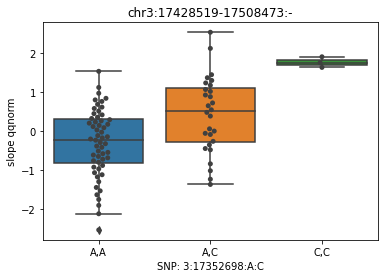

87it [04:00,  2.76s/it]


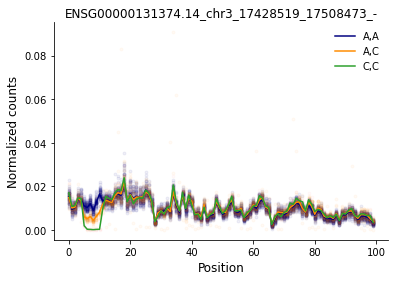

ENSG00000128607.14_chr7_130070809_130096920_+
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19138', 'NA18877', 'NA18909', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA18867', 'NA19092', 'NA18923', 'NA19114', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18522', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA19117', 'NA18862', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA18915', 'NA18858', 'NA19247', 'NA18913', 'NA18924', 'NA19225', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA19206', 'NA19098', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19143', 'NA19107', 'NA19150', 'NA19201', 'NA18504', 'NA19160', 'NA19140', 'NA19210', 'NA18852'

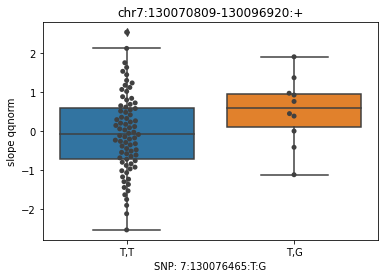

87it [04:00,  2.77s/it]


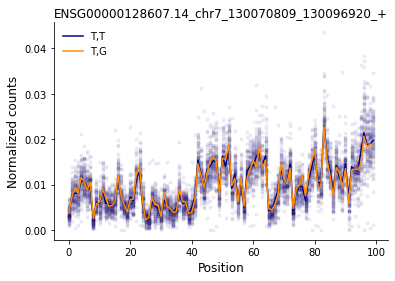

ENSG00000121895.8_chr4_38998909_39032225_-
0|0
['NA18508']
0|1
['NA19209', 'NA19143', 'NA18877', 'NA19107', 'NA19137', 'NA19119', 'NA18934', 'NA19150', 'NA19092', 'NA18923', 'NA18868', 'NA19121', 'NA18497', 'NA19239', 'NA19108', 'NA18498', 'NA19102', 'NA19117', 'NA18504', 'NA19247', 'NA19130', 'NA18516', 'NA18505', 'NA19098', 'NA19200']
1|1
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19138', 'NA18909', 'NA18507', 'NA19203', 'NA19141', 'NA18867', 'NA19201', 'NA19114', 'NA19236', 'NA18519', 'NA18522', 'NA19238', 'NA18510', 'NA18523', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19131', 'NA19257', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA18862', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA19160', 'NA18915', 'NA18858', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA18852', 'NA19206', 'NA19146', 'NA1909

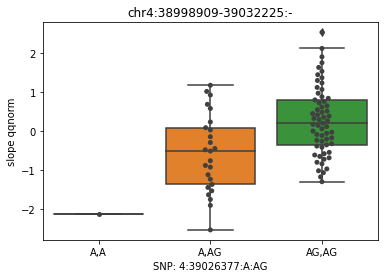

87it [04:00,  2.76s/it]


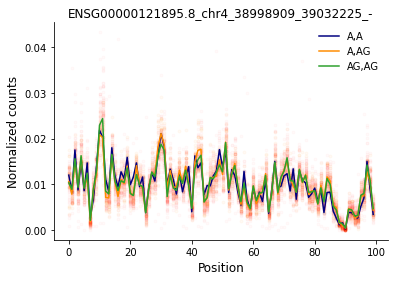

ENSG00000138101.18_chr2_25482873_25531472_-
0|0
['NA18913', 'NA19210', 'NA18881']
0|1
['NA19214', 'NA19153', 'NA19152', 'NA19209', 'NA18877', 'NA18507', 'NA19137', 'NA19119', 'NA18934', 'NA19150', 'NA19092', 'NA18923', 'NA19114', 'NA19236', 'NA19121', 'NA18522', 'NA19238', 'NA18508', 'NA18523', 'NA19093', 'NA19101', 'NA18520', 'NA19131', 'NA19108', 'NA19213', 'NA18862', 'NA18870', 'NA18499', 'NA19118', 'NA18915', 'NA18924', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18516', 'NA18852', 'NA19206', 'NA19098', 'NA18917']
1|1
['NA18876', 'NA19096', 'NA19143', 'NA19138', 'NA18909', 'NA19107', 'NA19203', 'NA19141', 'NA18867', 'NA19201', 'NA18868', 'NA18519', 'NA18497', 'NA18510', 'NA18486', 'NA18910', 'NA19239', 'NA19257', 'NA19122', 'NA19190', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA19117', 'NA18879', 'NA19198', 'NA18504', 'NA19160', 'NA18858', 'NA19247', 'NA19140', 'NA19225', 'NA19171', 'NA18853', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA19130', 'NA18505', 'NA19200', 'NA191

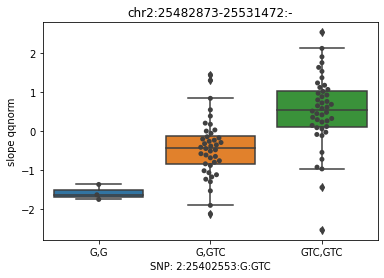

87it [04:01,  2.78s/it]


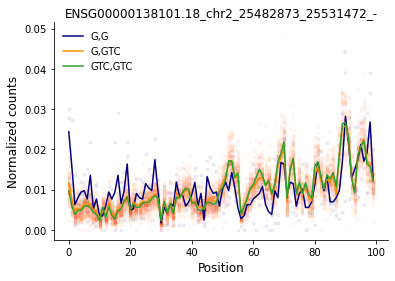

ENSG00000140386.13_chr15_76574284_76621763_-
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19201', 'NA19236', 'NA18868', 'NA19121', 'NA18519', 'NA18497', 'NA18508', 'NA18510', 'NA18523', 'NA19093', 'NA18910', 'NA19101', 'NA19239', 'NA19131', 'NA19257', 'NA19108', 'NA19190', 'NA19213', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA19117', 'NA18862', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18855', 'NA19184', 'NA19127', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19098', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19137', 'NA19114', 'NA18522', 'NA19238', 'NA18486', 'NA18520', 'NA19122', 'NA18870', 'NA19210', 'NA18864']

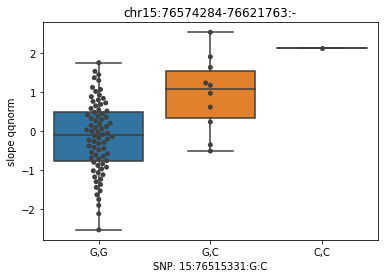

87it [04:01,  2.78s/it]


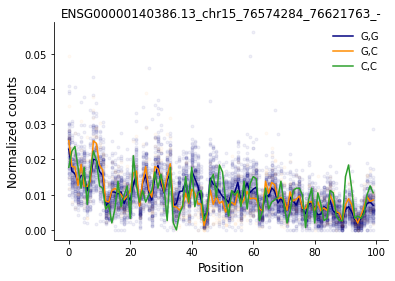

ENSG00000121749.15_chr12_71897941_71907021_+
0|0
['NA19214', 'NA18876', 'NA19096', 'NA19153', 'NA19152', 'NA19209', 'NA19143', 'NA19138', 'NA18877', 'NA18909', 'NA19107', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19141', 'NA19150', 'NA18867', 'NA19092', 'NA18923', 'NA19201', 'NA19236', 'NA18868', 'NA18519', 'NA18522', 'NA18497', 'NA19238', 'NA18508', 'NA18510', 'NA19093', 'NA18486', 'NA18910', 'NA19101', 'NA18520', 'NA19239', 'NA19131', 'NA19257', 'NA19122', 'NA19190', 'NA19213', 'NA19099', 'NA18498', 'NA19102', 'NA19117', 'NA18862', 'NA18870', 'NA18879', 'NA19198', 'NA18499', 'NA19118', 'NA18504', 'NA19160', 'NA18858', 'NA19247', 'NA19140', 'NA18913', 'NA18924', 'NA19225', 'NA19210', 'NA18881', 'NA19171', 'NA18853', 'NA18511', 'NA19207', 'NA19128', 'NA19147', 'NA18855', 'NA18864', 'NA19184', 'NA19127', 'NA18516', 'NA18505', 'NA18852', 'NA19206', 'NA19098', 'NA19200', 'NA19146', 'NA19095', 'NA18917']
0|1
['NA19114', 'NA19121', 'NA18523', 'NA19108', 'NA18502', 'NA18915',

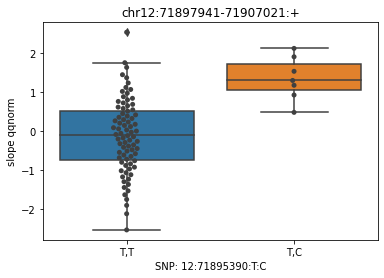

87it [04:00,  2.76s/it]


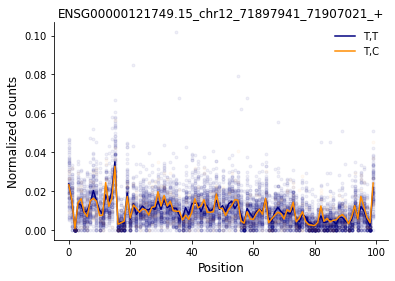

In [20]:
# processSampleIntron('NA19101', 'ENSG00000198216.12_chr1_181511510_181577765_+')


# plot_slopes_genotype(vcf, slopes, sQTLs, intron)


for intron in slopeQTLs.loc[valid_introns].sort_values('slope').index:
    print(intron)
    intron_idx = intron #+ intron.split('_')[0]
    try:
        v1, v2 = plot_SNP(vcf, slopes_qqnormed[samples], slopeQTLs, intron_idx)


        listas = plot_slopes_genotype(vcf, slopes_qqnormed[samples], slopeQTLs, intron)


        fig, ax = plt.subplots()

        if len(listas[0])>0:
            for l in listas[0]:
                n = np.sum(l)
                ax.scatter(range(100), np.array(l)/np.sum(l), c='navy', alpha=0.06, marker='.')

        if len(listas[1])>0:
            for l in listas[1]:
                n = np.sum(l)
                ax.scatter(range(100), np.array(l)/np.sum(l), c='darkorange', alpha=0.04, marker='.')

        if len(listas[2])>0:
            for l in listas[2]:
                n = np.sum(l)
                ax.scatter(range(100), np.array(l)/np.sum(l), c='red', alpha=0.02, marker='.')


        if len(listas[0])>0:
            ax.plot(range(100), np.array(listas[0]).sum(axis=0)/np.array(listas[0]).sum().sum(), c='navy', label=v1+','+v1)
        if len(listas[1])>0:
            ax.plot(range(100), np.array(listas[1]).sum(axis=0)/np.array(listas[1]).sum().sum(), c='darkorange', label=v1+','+v2)
        if len(listas[2])>0:
            ax.plot(range(100), np.array(listas[2]).sum(axis=0)/np.array(listas[2]).sum().sum(), c=x[2], label=v2+','+v2)

        ax.set_title(intron)
        ax.set_xlabel('Position', size=12)
        ax.set_ylabel('Normalized counts', size=12)

        ax.legend(frameon=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.show()

    except:
        continue

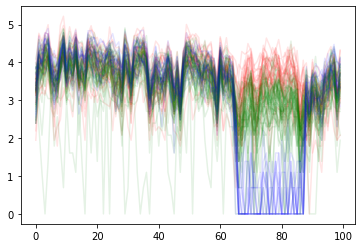

In [246]:
for l in listas[0]:
    n = np.sum(l)
    plt.plot(range(100), np.log1p(np.array(l)), c='red', alpha=0.1)
    
for l in listas[1]:
    n = np.sum(l)
    plt.plot(range(100), np.log1p(np.array(l)), c='green', alpha=0.1)
    
for l in listas[2]:
    n = np.sum(l)
    plt.plot(range(100), np.log1p(np.array(l)), c='blue', alpha=0.1)

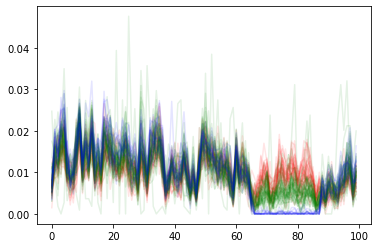

In [247]:
for l in listas[0]:
    n = np.sum(l)
    plt.plot(range(100), np.array(l)/np.sum(l), c='red', alpha=0.1)
    
for l in listas[1]:
    n = np.sum(l)
    plt.plot(range(100), np.array(l)/np.sum(l), c='green', alpha=0.1)
    
for l in listas[2]:
    n = np.sum(l)
    plt.plot(range(100), np.array(l)/np.sum(l), c='blue', alpha=0.1)

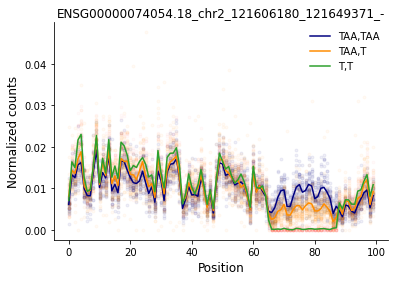

In [249]:
fig, ax = plt.subplots()
for l in listas[0]:
    n = np.sum(l)
    ax.scatter(range(100), np.array(l)/np.sum(l), c='navy', alpha=0.06, marker='.')
    
for l in listas[1]:
    n = np.sum(l)
    ax.scatter(range(100), np.array(l)/np.sum(l), c='darkorange', alpha=0.04, marker='.')
    
for l in listas[2]:
    n = np.sum(l)
    ax.scatter(range(100), np.array(l)/np.sum(l), c='red', alpha=0.02, marker='.')
    
    
ax.plot(range(100), np.array(listas[0]).sum(axis=0)/np.array(listas[0]).sum().sum(), c='navy', label='TAA,TAA')
ax.plot(range(100), np.array(listas[1]).sum(axis=0)/np.array(listas[1]).sum().sum(), c='darkorange', label='TAA,T')
ax.plot(range(100), np.array(listas[2]).sum(axis=0)/np.array(listas[2]).sum().sum(), c=x[2], label='T,T')

ax.set_title('ENSG00000074054.18_chr2_121606180_121649371_-')
ax.set_xlabel('Position', size=12)
ax.set_ylabel('Normalized counts', size=12)

ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [1]:
fig, ax = plt.subplots()
for l in listas[0]:
    n = np.sum(l)
    ax.scatter(range(100), np.array(l)/np.sum(l), c='navy', alpha=0.06, marker='.')
    
for l in listas[1]:
    n = np.sum(l)
    ax.scatter(range(100), np.array(l)/np.sum(l), c='darkorange', alpha=0.04, marker='.')
    
for l in listas[2]:
    n = np.sum(l)
    ax.scatter(range(100), np.array(l)/np.sum(l), c='red', alpha=0.02, marker='.')
    
    
ax.plot(range(100), np.array(listas[0]).sum(axis=0)/np.array(listas[0]).sum().sum(), c='navy', label='TAA,TAA')
ax.plot(range(100), np.array(listas[1]).sum(axis=0)/np.array(listas[1]).sum().sum(), c='darkorange', label='TAA,T')
ax.plot(range(100), np.array(listas[2]).sum(axis=0)/np.array(listas[2]).sum().sum(), c=x[2], label='T,T')

ax.set_title('ENSG00000074054.18_chr2_121606180_121649371_-')
ax.set_xlabel('Position', size=12)
ax.set_ylabel('Normalized counts', size=12)

ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
ENSG00000171045.16_chr8_142354763_142403103_-

0|0
['NA19152', 'NA19107', 'NA19114', 'NA18510', 'NA18924', 'NA19171', 'NA18853', 'NA19127']
0|1
['NA19214', 'NA18876', 'NA19153', 'NA18877', 'NA18909', 'NA18507', 'NA19137', 'NA19203', 'NA19119', 'NA18934', 'NA19150', 'NA19092', 'NA18868', 'NA18497', 'NA18486', 'NA18910', 'NA19101', 'NA19239', 'NA19213', 'NA19117', 'NA18870', 'NA18499', 'NA18915', 'NA19247', 'NA19210', 'NA19207', 'NA19147', 'NA18864', 'NA19206', 'NA19098', 'NA19146', 'NA18917']
1|1
['NA19096', 'NA19209', 'NA19143', 'NA19138', 'NA19141', 'NA18867', 'NA18923', 'NA19201', 'NA19236', 'NA19121', 'NA18519', 'NA18522', 'NA19238', 'NA18508', 'NA18523', 'NA19093', 'NA18520', 'NA19131', 'NA19257', 'NA19108', 'NA19122', 'NA19190', 'NA19099', 'NA18502', 'NA18498', 'NA19102', 'NA18862', 'NA18879', 'NA19198', 'NA19118', 'NA18504', 'NA19160', 'NA18858', 'NA19140', 'NA18913', 'NA19225', 'NA18881', 'NA18511', 'NA19128', 'NA19184', 'NA19130', 'NA18516', 'NA18505', 'NA18852', 'NA19200', 'NA19095']
8:142404143:G:A


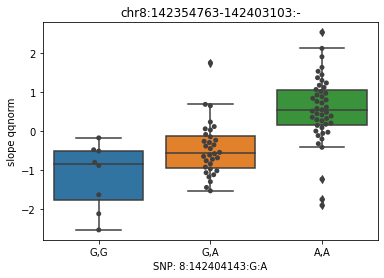

86it [03:58,  2.77s/it]


In [23]:
samples = [x for x in samples if x != 'NA18855']
v1, v2 = plot_SNP(vcf, slopes_qqnormed[samples], slopeQTLs, 'ENSG00000171045.16_chr8_142354763_142403103_-')

listas = plot_slopes_genotype(vcf, slopes_qqnormed[samples], slopeQTLs, 'ENSG00000171045.16_chr8_142354763_142403103_-')


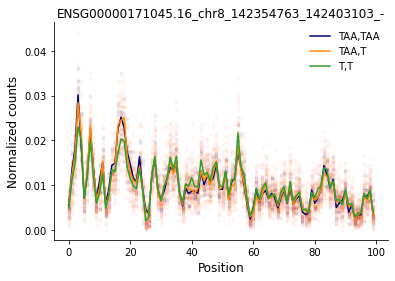

In [25]:
fig, ax = plt.subplots()
for l in listas[0]:
    n = np.sum(l)
    ax.scatter(range(100), np.array(l)/np.sum(l), c='navy', alpha=0.06, marker='.')
    
for l in listas[1]:
    n = np.sum(l)
    ax.scatter(range(100), np.array(l)/np.sum(l), c='darkorange', alpha=0.04, marker='.')
    
for l in listas[2]:
    n = np.sum(l)
    ax.scatter(range(100), np.array(l)/np.sum(l), c='red', alpha=0.02, marker='.')
    
    
ax.plot(range(100), np.array(listas[0]).sum(axis=0)/np.array(listas[0]).sum().sum(), c='navy', label='TAA,TAA')
ax.plot(range(100), np.array(listas[1]).sum(axis=0)/np.array(listas[1]).sum().sum(), c='darkorange', label='TAA,T')
ax.plot(range(100), np.array(listas[2]).sum(axis=0)/np.array(listas[2]).sum().sum(), c=x[2], label='T,T')

ax.set_title('ENSG00000171045.16_chr8_142354763_142403103_-')
ax.set_xlabel('Position', size=12)
ax.set_ylabel('Normalized counts', size=12)

ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()